# **Full Fine-Tuning with Fully Sharded Data Parallel (FSDP)**

### **Full Fine-Tuning with Fully Sharded Data Parallel Readme:**

For more information on Full Fine-Tuning with Fully Sharded Data Parallel, refer to the [Full Fine-Tuning with Fully Sharded Data Parallel Readme](../full_finetuning_with_fsdp_readme.md).

### **About This Notebook:**

This notebook demonstrates `Full Fine-Tuning with Fully Sharded Data Parallel`. Compared to the [Full Fine-Tuning Notebook](../../2.4_full_finetuning/run_1_a100_80g_x1/full_finetuning.ipynb), the following modifications have been made:

1. User does not need to set `device_map` (it is set to `None` in this notebook). Instead, the Hugging Face library leverages PyTorch's Fully Sharded Data Parallel to automatically shard model parameters across GPUs based on the accelerate configuration file (`my_accelerate_config.yaml`), eliminating the need for an explicitly defined `device_map` during multi-GPU training. During FSDP training, multiple ranks (processes) are initiated in parallel, with each rank allocating its sharded model layers to the GPU it is bound to. Specifically, once FSDP training starts and during the first forward pass (e.g., model evaluation or model training), the trainer's internal accelerator not only initializes an optimizer and moves it to the designated GPU but also shards the model weights and moves them to the appropriate GPU. At this point, the module becomes wrapped and located on the GPU. Please note that if inference is run before the first training step, since `device_map` is set to `None`, the model must be manually moved to the GPU(s) before running inference.

2. Two accelerators are used in each rank (process):
   - `The first accelerator` is initialized at the beginning of each rank (process). This `utility accelerator` is used for read-only operations, such as providing the current rank (process) ID to help bind the rank to its corresponding GPU. It also uses the `wait_for_everyone()` function to synchronize across ranks.
   - `The second accelerator` is initialized by the trainer when specific conditions are detected, such as multi-GPU or distributed training, mixed-precision training, or gradient accumulation. This trainer's `internal accelerator` moves dataloaders from CPU to GPU (via `prepare()`) after the trainer is set up and moves the model (weights and gradients) and optimizer to the GPU once training starts. 
   - Both accelerators share the same `AcceleratorState`, which inherits the distributed setup (process group, device mapping, etc.) from the environment variables or initialization process specific to the launcher used (e.g., `notebook_launcher` or `accelerate launch`).

3. An optional custom callback function is defined to validate that layer sharding is evenly distributed across GPUs in FSDP. During the first training step, the percentage of parameters sharded on each GPU is printed to confirm that layer sharding is evenly distributed across GPUs. Additionally, this callback reports VRAM usage and prints details of the mini-batch dispatched to the current rank, including the mini-batch size and the first data in the mini-batch. These details ensure that each rank (GPU) processes a distinct batch of data from the dataset, verifying proper data parallelism.

4. Full fine-tuning-related pre-training and training steps are encapsulated in a workflow function. The following modifications were made to support FSDP:  
   4.1. Initialize a utility accelerator to provide the current rank (process) ID, which helps bind the current rank to its corresponding GPU.  
   4.2. Override the `print()` function to prepend a prefix string. This ensures individual rank outputs can be identified even when all ranks' outputs are mixed in the terminal, facilitating debugging.  
   4.3. Use only the main rank (rank 0, GPU 0) for specific tasks such as account logins, file writing, and model inference to avoid redundant logins and file conflicts in multi-process environments.  
   4.4. Set `use_fsdp=True` to apply additional trainer configurations for FSDP. This disables gradient checkpointing-related settings in `TrainingArguments` and uses `activation_checkpointing` from the accelerate configuration instead.  
   4.5. Scale up the learning rate for multi-GPU training. Typically, the learning rate increases proportionally with the batch size. In this notebook, the effective batch size for multi-GPU training scales linearly with the number of GPUs allocated for training. For 2 A100 GPUs, the effective batch size is `14 * 2 = 28`, and for 4 A6000 GPUs, the effective batch size is `10 * 4 = 40`. Additionally, the square root scaling rule (instead of the linear scaling rule) is used for learning rate adjustment to ensure better stability. In the [Full Fine-Tuning Notebook](../../2.4_full_finetuning/run_1_a100_80g_x1/full_finetuning.ipynb), single GPU training uses `batch_size=10` and `learning_rate=1e-5`. For 2 A100 GPUs, the scaled learning rate is calculated as `scaled_learning_rate = sqrt(28/10) * learning_rate = 1.7e-5`. Similarly, for 4 A6000 GPUs, the scaled learning rate is `scaled_learning_rate = sqrt(40/10) * learning_rate = 2e-5`.

5. Since the training workflow function is saved in an external Python file, removing the Python cache folder (`__pycache__`) and restarting the kernel after modifying the workflow content ensures that the notebook does not pick up old cached content.

6. Two approaches are demonstrated to execute the training workflow function: using `notebook_launcher` or `accelerate launch`.

7. During training, the `save_state()` function is called to save the model checkpoint (weights) in a `sharded-state`. After training, the fine-tuned model is loaded from the checkpoint with the minimum loss by merging the `sharded-state` checkpoint weights into the `full-state` base model weights. Please note that it is crucial to ensure the `state_dict` (whether in `sharded-state` or `full-state`) is consistent across all GPUs. Mixing some GPUs in `sharded-state` and others in `full-state` can lead to unexpected behavior.

### **Supporting Python and YAML Files:**

- `my_login.py`: Contains reusable login functions (e.g., for Hugging Face and Weights & Biases). Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils.py`: Contains general-purpose utility functions for fine-tuning. Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils_full_finetuning_with_fsdp.py`: Contains utility functions specific to full fine-tuning with Fully Sharded Data Parallel. Created within this notebook.
- `my_workflow_full_finetuning_with_fsdp.py`: Contains a workflow function that encapsulates full fine-tuning-related pre-training and training steps, along with the modifications required for FSDP. Created within this notebook.
- `my_accelerate_config.yaml`: Contains accelerate configuration for FSDP. Created within this notebook.

### **Experiment Settings:**

This experiment is conducted within a pod (container instance) provided by [RunPod](https://runpod.io). The specific configurations are as follows:

- `Template (Docker Container Image)`: runpod/pytorch:2.4.0-py3.11-cuda12.4.1-devel-ubuntu22.04
- `Volume Disk`: 2000GB (model checkpoints storage)
- `GPU Setup`: 2 Nvidia A100 SXM GPUs (80GB VRAM)


---
# **Step 1: Preparation**

## 1.1 Install Necessary Python Packages

In [1]:
!python -m pip install -q -U pip            # [optional] upgrade pip
!pip install huggingface_hub==0.25.1 -q -U  # hf lib to login to huggingface and download dataset, model
!pip install hf_transfer==0.1.8 -q -U       # hf lib to speed up huggingface data transfer 
!pip install transformers==4.46.0 -q -U     # hf lib to load model and processor(tokenizer)
!pip install accelerate==0.34.2 -q -U       # hf lib to support 'device_map', restart kernel required after installation
!pip install flash-attn==2.6.3 -q -U        # to reduce vram usage for llama model, restart kernel recommended after installation
!pip install datasets==3.0.0 -q -U          # hf lib to load dataset
!pip install peft==0.13.0 -q -U             # hf lib to support lora fine-tuning
!pip install matplotlib==3.9.2 -q -U        # to plot similarity score comparison graphs
!pip install tensorboard==2.18.0 -q -U      # to support logging with tensorboard
!pip install wandb==0.18.1 -q -U            # to support logging with weights and biases (wandb)
!pip install ipython==8.28.0 -q -U          # to enable %% magic functions in a jupyter notebook


Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet


## 1.2 Restart Kernel to Activate Installed Packages

---
# **Step 2: Pre-training & Training**

## 2.1 Create an Accelerate Configuration File for Fully Sharded Data Parallel Training  

In this notebook, we create an accelerate configuration file (`my_accelerate_config.yaml`) based on below considerations:  

1. Full fine-tuning is trained on 1 node (computer) with 2 A100 or 4 A6000 GPUs.  

2. Choose PyTorch Fully Sharded Data Parallel (`FULL_SHARD`) for training, which shards parameters, gradients, and optimizer states, and is equivalent to Deepspeed ZeRO Stage 3.  

3. For model shard (wrap) strategy:  
    3.1. `model._no_split_modules` prevents specified modules from being split across shards during parallel training and can influence model wrapping in FSDP. However, in this notebook, we don't leverage it for model sharding. Instead, we use `fsdp_auto_wrap_policy` and `fsdp_transformer_layer_cls_to_wrap` to control model wrapping and sharding.  
    3.2. Attn and MLP layers will be sharded by listing their class names in `fsdp_transformer_layer_cls_to_wrap`. Norm layers are not sharded due to their small sizes. Also, Embedding layers are not sharded since leaving full Embedding layers on each GPU helps reduce cross-GPU communication costs during training.  

4. In order to maximize GPU utilization:  
    4.1. Parameters and gradients are not offloaded to CPU.  
    4.2. Prefetch is enabled on both forward and backward passes to reduce time spent on waiting for shards.  

5. In order to minimize GPU VRAM usage:  
    5.1. Model state (model checkpoint) is stored in a sharded state during training. Along with the included metadata, we can recover full-state model weights from the sharded-state weights for model saving.  
    5.2. When parameters are inactive, for instance, training on the current wrapper (layer) is complete, for computing efficiency, `use_orig_params` still reserves a full-size VRAM for inactive parameters, although only a sharded part is needed to be kept in VRAM. We disable `use_orig_params` so that only the required sharded part of inactive parameters will be kept in VRAM, and the rest of the reserved VRAM can be released to other wrappers (layers) for active computations.  
    5.3. Enable activation checkpoint: Not all intermediate activations are stored. Instead, we only store a few as checkpoints, and the missing ones are recomputed on the fly during the backward pass.  

6. For model loading:  
    6.1. Use two-stage model loading to avoid OOM (out-of-memory) errors.  
        - `Two-stage model loading`: The model is loaded progressively from the source to CPU RAM and then to GPU VRAM. During this process, each wrapper is fully loaded into CPU RAM first, then split and distributed across GPUs (e.g., GPU0, GPU1, GPU2).  
        - `One-stage model loading`: The model is loaded directly from the source to GPU VRAM. During progressive loading, each wrapper needs to be fully loaded on GPU0 VRAM before being split and distributed to GPU0, GPU1, GPU2, which can lead to OOM issues on GPU0.  
        
    6.2. Enable `fsdp_sync_module_states`: The same model component may demonstrate different weights across multiple GPUs due to, for instance, random initialization using a normal distribution. With synchronization, all GPUs are ensured to be initialized with the same weights before training begins.  

7. In order to stabilize training: Set `mixed_precision` to `fp16`. [Link1](https://huggingface.co/blog/deepspeed-to-fsdp-and-back) and [Link2](https://huggingface.co/docs/accelerate/concept_guides/fsdp_and_deepspeed) suggest choosing `mixed_precision` to `fp16` in FSDP, which will automatically upcast precision to `fp32` during training for improved stability.  


There are two approaches to create an accelerate configuration file for FSDP: `directly edit` or use the `accelerate config` command.  

### **(Approach 1) Directly Edit an Accelerate Configuration File:**

In [1]:
# Define the accelerate configuration as a dictionary
accelerate_config = {
    "compute_environment": "LOCAL_MACHINE",
    "debug": False,
    "distributed_type": "FSDP",
    "downcast_bf16": "no",
    "enable_cpu_affinity": False,
    "fsdp_config": {
        "fsdp_activation_checkpointing": True,
        "fsdp_auto_wrap_policy": "TRANSFORMER_BASED_WRAP",
        "fsdp_backward_prefetch": "BACKWARD_PRE",
        "fsdp_cpu_ram_efficient_loading": True,
        "fsdp_forward_prefetch": True,
        "fsdp_offload_params": False,
        "fsdp_sharding_strategy": "FULL_SHARD",
        "fsdp_state_dict_type": "SHARDED_STATE_DICT",
        "fsdp_sync_module_states": True,
        "fsdp_transformer_layer_cls_to_wrap": "Idefics2VisionFlashAttention2,Idefics2VisionMLP,Idefics2MLP,Idefics2PerceiverFlashAttention2,MistralFlashAttention2,MistralFlashAttention2,MistralMLP",
        "fsdp_use_orig_params": False
    },
    "machine_rank": 0,
    "main_training_function": "main",
    "mixed_precision": "bf16",
    "num_machines": 1,
    "num_processes": 2,
    "rdzv_backend": "static",
    "same_network": True,
    "tpu_env": [],
    "tpu_use_cluster": False,
    "tpu_use_sudo": False,
    "use_cpu": False
}

# Write the accelerate configuration to a YAML file
import yaml
with open("./my_accelerate_config.yaml", 'w') as f:
    yaml.dump(accelerate_config, f)

### **(Approach 2) Use `accelerate config` to Create an Accelerate Configuration File:**

Execute the command `accelerate config --config_file './my_accelerate_config.yaml'` in a terminal, then follow the prompts below to create an accelerate configuration YAML file:

In which compute environment are you running? -> `This machine`  
Which type of machine are you using? -> `multi-GPU`  
How many different machines will you use (use more than 1 for multi-node training)? -> `1`  
Should distributed operations be checked while running for errors? This can avoid timeout issues but will be slower. -> `NO`  
Do you wish to optimize your script with torch dynamo? -> `NO`  
Do you want to use DeepSpeed? -> `NO`  
Do you want to use FullyShardedDataParallel? -> `yes`  
What should be your sharding strategy? -> `FULL_SHARD`  
Do you want to offload parameters and gradients to CPU? -> `NO`  
What should be your auto wrap policy? -> `TRANSFORMER_BASED_WRAP`  
Do you want to use the model's _no_split_modules to wrap. -> `NO`  
Specify the comma-separated list of transformer layer class names (case-sensitive) to wrap -> `Idefics2VisionFlashAttention2,Idefics2VisionMLP,Idefics2MLP,Idefics2PerceiverFlashAttention2,MistralFlashAttention2,MistralFlashAttention2,MistralMLP`  
What should be your FSDP's backward prefetch policy? -> `BACKWARD_PRE`  
What should be your FSDP's state dict type? -> `SHARDED_STATE_DICT`  
Do you want to enable FSDP's forward prefetch policy? -> `yes`  
Do you want to enable FSDP's use_orig_params feature? -> `no`  
Do you want to enable CPU RAM efficient model loading? -> `YES`  
Do you want to enable FSDP activation checkpointing? -> `yes`  
How many GPU(s) should be used for distributed training? -> `2`  
Do you wish to use mixed precision? -> `bf16`  


## 2.2 Define Utility Functions for Full Fine-Tuning with Fully Sharded Data Parallel

In [2]:
%%writefile my_utils_full_finetuning_with_fsdp.py
#--------------- Functions in Full Fine-Tuning with Fully Sharded Data Parallel ---------------
# 1) Override the built-in print() function to prepend a prefix string to all printed messages.
import builtins
def add_prefix_to_print_function(prefix_string):
    original_print = builtins.print                               # Save a reference to the original print function
    def custom_print(*args, **kwargs):                            # Define a custom print function
        args = (f"{prefix_string} {' '.join(map(str, args))}",)   # Prepend the prefix string to the original print message
        original_print(*args, **kwargs)                           # Call the original print function with the modified arguments
    builtins.print = custom_print                                 # Override the built-in print function

# 2) Print utility accelerator info to the terminal
def print_util_accelerator_info(accelerator):
    print(f'==> Printing utility accelerator info...')
    print(f'==> accelerator.distributed_type: {accelerator.distributed_type}')                                 # Current distributed training mode: FSDP
    print(f'==> accelerator.state.num_processes: {accelerator.state.num_processes}')                           # Total number of processes across all devices
    print(f'==> accelerator.state.process_index: {accelerator.state.process_index}')                           # Global index of the current process among all device processes
    print(f'==> accelerator.state.local_process_index: {accelerator.state.local_process_index}')               # Local index of the current process on its assigned device
    print(f'==> accelerator.state.device: {accelerator.state.device}')                                         # Device assigned to the current process
    print(f'==> accelerator.state.mixed_precision: {accelerator.state.mixed_precision}')                       # Precision mode used for training (e.g., FP16, BF16, FP32)
    if hasattr(accelerator.state, 'fsdp_plugin'):                                                              # Details of the FSDP plugin, if configured
        print(f'==> accelerator.state.fsdp_plugin: {accelerator.state.fsdp_plugin.__dict__}')
    else:
        print(f'==> accelerator.state.fsdp_plugin: Not Specified')

# 3) Print trainer info to the terminal
def print_trainer_info(trainer):
    print(f'==> Printing trainer info...')
    # Print trainer.model 
    print(f'==> trainer.model is located on device: {next(trainer.model.parameters()).device}')                # Device where the model is located
    # Print trainer.accelerator internal state 
    accelerator = trainer.accelerator       
    print(f'==> trainer.accelerator.distributed_type: {accelerator.distributed_type}')                         # Current distributed training mode: FSDP
    print(f'==> trainer.accelerator.state.num_processes: {accelerator.state.num_processes}')                   # Total number of processes across all devices
    print(f'==> trainer.accelerator.state.process_index: {accelerator.state.process_index}')                   # Global index of the current process among all device processes
    print(f'==> trainer.accelerator.state.local_process_index: {accelerator.state.local_process_index}')       # Local index of the current process on its assigned device
    print(f'==> trainer.accelerator.state.device: {accelerator.state.device}')                                 # device assigned to the current process
    print(f'==> trainer.accelerator.state.mixed_precision: {accelerator.state.mixed_precision}')               # Precision mode used for training (e.g., FP16, BF16, FP32)
    if hasattr(accelerator.state, 'fsdp_plugin'):                                                              # Details of the FSDP plugin, if configured
        print(f'==> trainer.accelerator.state.fsdp_plugin: {accelerator.state.fsdp_plugin.__dict__}')
    else:
        print(f'==> trainer.accelerator.state.fsdp_plugin: Not Specified')
    # Print trainer.train_dataloader
    train_dataloader = trainer.get_train_dataloader()
    print(f'==> trainer.train_dataloader: {train_dataloader}')                                                  # The dataloader used for training
    print(f'==> trainer.train_dataloader._is_accelerate_prepared: {train_dataloader._is_accelerate_prepared}')  # Whether the dataloader is prepared by accelerate
    print(f'==> trainer.train_dataloader.device: {train_dataloader.device}')                                    # Device assigned to the training dataloader
    # Print trainer.eval_dataloader
    eval_dataloader = trainer.get_eval_dataloader()
    print(f'==> trainer.eval_dataloader: {eval_dataloader}')                                                    # The dataloader used for evaluation
    print(f'==> trainer.eval_dataloader._is_accelerate_prepared: {eval_dataloader._is_accelerate_prepared}')    # Whether the dataloader is prepared by accelerate
    print(f'==> trainer.eval_dataloader.device: {eval_dataloader.device}')                                      # Device assigned to the evaluation dataloader
    # Print trainer.optimizer
    if trainer.optimizer:                                                                                       # Details of the optimizer, if defined
        optimizer = trainer.optimizer
        print(f'==> trainer.optimizer type: {type(optimizer)}')                                                 # Type of optimizer used
        print(f"==> trainer.optimizer.param_groups.initial_lr: {optimizer.param_groups[0]['initial_lr']}")      # Initial learning rate of the optimizer
        print(f'==> trainer.optimizer._is_accelerate_prepared: {optimizer._is_accelerate_prepared}')            # Whether the optimizer is prepared by accelerate
        print(f"==> trainer.optimizer on device: {optimizer.param_groups[0]['params'][0].device}")              # Device where the optimizer parameters are located
    else:
        print(f'==> trainer.optimizer is not available.') 

# 4) Print brief model wrapping status to the terminal and save detailed wrapping status to a file
# Note: This function is highly customized for the Idefics2 model
import os
import torch.distributed.fsdp as fsdp
def print_module_wrapping_status_to_file(model, filename):
    print(f'==> Printing module wrapping status...')
    filepath = os.path.dirname(filename)
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    file = open(filename, 'w')

    # Define class names considered as module groups
    module_group_class_name = {
        'Idefics2ForConditionalGeneration', 
        'Idefics2Model', 
        'Idefics2VisionTransformer', 
        'Idefics2VisionEmbeddings',
        'Idefics2Encoder',
        'Idefics2EncoderLayer', 
        'Idefics2Connector', 
        'Idefics2PerceiverResampler',
        'ModuleList', 
        'MistralModel',
        'Idefics2PerceiverLayer', 
        'MistralDecoderLayer'
    }

    wrapped_module = 0
    unwrapped_module = 0
    # Iterate through model modules and categorize them
    for name, module in model.named_modules():
        if name == '':                                                                # Top-level module
            file.write(f'top_module:         {name} ({type(module).__name__})\n')
        elif type(module).__name__ in module_group_class_name:                        # Module group
            file.write(f'module group:       {name} ({type(module).__name__})\n')
        elif '._fsdp_wrapped_module' in name:                                         # FSDP-wrapped submodule
            file.write(f'                    {name}  ({type(module).__name__})\n')
        else:                                                                         # Regular module
            if isinstance(module, fsdp.FullyShardedDataParallel):                     # FSDP-wrapped module
                wrapped_module += 1
                file.write(f'--fsdp_wrap_module: {name} ({type(module).__name__})\n')
            else:                                                                     # Unwrapped module
                unwrapped_module += 1
                file.write(f'--unwrap-module:    {name} ({type(module).__name__})\n')

    # Calculate total modules and percentage of wrapped modules
    total_module = wrapped_module + unwrapped_module
    wrapped_percentage = (100 * wrapped_module / total_module) if total_module > 0 else 0
    print(f'==> Total modules: {total_module}, FSDP wrapped modules: {wrapped_percentage:.2f}%')
    print(f'==> For complete module wrapping status info, refer to {filename}')
    file.write(f'==> Total modules: {total_module}, FSDP wrapped modules: {wrapped_percentage:.2f}%\n')
    file.close()

# 5) Select Layers for Full Fine-Tuning
def select_layers_for_full_fine_tuning(model, module_list):
    print("==> Selecting Layers for Full Fine-Tuning...")
    for name, param in model.named_parameters():
        param.requires_grad = False                                                   # Freeze all parameters by default
        for module in module_list:
            if module in name and 'proj' in name:                                     # Set linear('proj') layers in the specified modules to trainable
                param.requires_grad = True
                break
    return model

# 6) Define a custom callback function to report VRAM usage, print mini-batch details, and display parameter sharding percentage on the current device.
# Note 1: At every training step, each GPU receives an individual mini-batch from the dataloader in FSDP. Printing the mini-batch size and the first data in the mini-batch at training step 1 helps validate that each GPU processes a different batch from the dataset, ensuring proper data parallelism.
# Note 2: At training step 1, printing the trainer's model type validates whether the model is FSDP-wrapped. Additionally, printing the percentage of parameters sharded on the current device validates that layer sharding is evenly distributed across GPUs.
import torch
from transformers import TrainerCallback
class CustomCallbackFSDP(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        # If the current process is using a GPU and this is the first training step:
        if torch.cuda.is_available() and state.global_step == 1:
            # Report VRAM usage
            gpu_id = torch.cuda.current_device()
            gpu_memory = torch.cuda.memory_allocated(gpu_id) / (1024 ** 3)
            gpu_max_memory = torch.cuda.max_memory_allocated(gpu_id) / (1024 ** 3)
            total_memory = torch.cuda.get_device_properties(gpu_id).total_memory / (1024 ** 3)
            print(f'Step {state.global_step}: Current VRAM usage: {gpu_memory:.2f} GB, Peak VRAM usage: {gpu_max_memory:.2f} GB, Total GPU VRAM: {total_memory:.2f} GB')

            # Print mini-batch size and the first data in the mini-batch
            train_dataloader = kwargs.get('train_dataloader')         # Retrieve the dataloader from kwargs
            if train_dataloader is not None:
                for batch in train_dataloader:
                    input_data = batch.get('input_ids', None)
                    if input_data is not None:
                        batch_size = input_data.size(0)               # Get the size of the mini-batch
                        first_input_data = input_data[0].tolist()     # Convert the first data in the mini-batch to a list
                        print(f'Step {state.global_step}: Mini-batch size: {batch_size}')
                        print(f'Step {state.global_step}: 1st data in mini-batch: {first_input_data}')
                    else:
                        print(f'Step {state.global_step}: No input data available in the mini-batch.')
                    break                                             # Stop after processing the first mini-batch to avoid iterating through the entire dataloader
            
            # Print model type to check if wrapped in FSDP
            model = kwargs.get('model')
            print(f'Step {state.global_step}: Trainer model type: {type(model)}')

            # For the first and last 15 model layers, print the percentage of parameters sharded on the current device
            display_size = 15
            named_params = list(model.named_parameters())
            layers_to_print = named_params[:display_size] + named_params[-display_size:]
            for name, param in layers_to_print:
                if hasattr(param, '_unpadded_unsharded_size'):        # FSDP mode; this attribute exists only in FSDP
                    total_params = param._unpadded_unsharded_size[0]  # In FSDP, param._unpadded_unsharded_size[0] is the total parameter count
                    shard_params = param.numel()                      # In FSDP, param.numel() and param._sharded_size[0] represent the sharded parameter count on the current device
                    shard_percentage = (shard_params / total_params) * 100 if total_params > 0 else 0
                    print(f'Step {state.global_step}: [FSDP Mode] Model Layer: {name}, Total Parameter Count: {total_params}, Sharded Parameter Count on device: {shard_params} ({shard_percentage:.2f}%)')
                else:
                    print(f'Step {state.global_step}: [Non-FSDP Mode] Model Layer: {name}, Total Parameter Count: {param.numel()}')  # In non-FSDP, param.numel() is the total parameter count


Overwriting my_utils_full_finetuning_with_fsdp.py


## 2.3 Wrap Pre-Training and Training Steps into a Training Workflow Function

In [3]:
%%writefile my_workflow_full_finetuning_with_fsdp.py
#--------------- A Training Workflow in Full Fine-Tuning with Fully Sharded Data Parallel ---------------
def training_workflow():
    import my_login
    import my_utils
    import my_utils_full_finetuning_with_fsdp

    # **Step 1: Rank (Process) Initialization**
    ## 1.1 Initialize an (Utility) Accelerator at the Beginning of Each Rank (Process)
    import torch
    from accelerate import Accelerator
    accelerator = Accelerator()
    rank = accelerator.process_index                                         # Get the current rank (process) ID
    torch.cuda.set_device(rank)                                              # Bind the current rank (process) to the GPU with the same ID (e.g., rank 0 to GPU 0, rank 1 to GPU 1, etc.)

    ## 1.2 Override print() to Prepend a Prefix String ('[RANK{current rank ID}:GPU{current GPU ID}]') to All Printed Messages
    gpu_id = torch.cuda.current_device()
    prefix_string = f'[RANK{rank}:GPU{gpu_id}]'
    my_utils_full_finetuning_with_fsdp.add_prefix_to_print_function(prefix_string)
    print(f'==> Process started...')

    # **Step 2: Pre-training**
    ## 2.1 Log in to Required Accounts (e.g., Hugging Face, Weights & Biases)
    if accelerator.is_main_process:                                           # Only use rank 0 to log in to avoid multiple logins
        # Log in to the Hugging Face account to access the Idefics2 model and the dataset
        my_login.login_hf()
        # Log in to the Weights & Biases account to enable tracking of training progress
        my_login.login_wandb()
    accelerator.wait_for_everyone()                                           # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.2 Print (Utility) Accelerator Info
    if accelerator.is_main_process:                                           # Use rank 0 only to print info to prevent redundant prints from multiple processes
        # Print (utility) accelerator info to verify that FSDP is properly configured and reflected in the accelerator state
        my_utils_full_finetuning_with_fsdp.print_util_accelerator_info(accelerator)
    accelerator.wait_for_everyone()                                           # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.3 Load the Processor (Tokenizer) and the Base Model
    # Load processor
    processor = my_utils.load_processor()
    # Load model
    base_model = my_utils.load_model(device_map=None)                         # device_map is derived from the accelerate configuration
    if accelerator.is_main_process:                                           # Only use rank 0 to write files to avoid multi-process file writing
        my_utils.print_processor_info_to_file(processor, './results/model_info/original_processor_info.txt')
        my_utils.print_model_info_to_file(base_model, './results/model_info/base_model_info.txt')
        my_utils.print_model_parameters_to_file(base_model, './results/model_info/base_model_parameters.txt')
    accelerator.wait_for_everyone()                                           # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.4 Load the Dataset
    # Load the Hugging Face dataset
    dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

    ## 2.5 Perform Inference with the Base Model to Establish a Baseline
    base_model.to(f'cuda:{rank}')                                             # Once FSDP training starts, model weights are automatically sharded and moved to GPUs. However, if we run inference before training and device_map is set to 'None', we must manually move the model to GPUs before running inference.
    if accelerator.is_main_process:                                           # Only use rank 0 to run inference to avoid multi-process file writing
        # Perform batch inference on the test set and save results to a CSV file
        my_utils.batch_inference_model(base_model, processor, dataset['test'], './results/inference_results/inference_results_before_finetuning.csv', 14)
        # Plot similarity scores from the inference CSV file, using thumbnails, and save the plot image locally
        my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv')],
                                        thumbnail_dir='./results/inference_results/thumbnail',
                                        plot_file_name='./results/inference_results/similarity_scores_before_finetuning.jpg'
        )
    accelerator.wait_for_everyone()                                           # Synchronize across all ranks to ensure rank 0 finishes

    # **Step 3: Training**
    ## 3.1 Add a Custom Padding Token
    # Set up pad token (<pad>) in the processor
    my_utils.setup_pad_token_in_processor(processor)
    # Set up pad token (<pad>) in the base model
    my_utils.setup_pad_token_in_model(base_model, processor)

    ## 3.2 Select Layers for Full Fine-Tuning
    # - Freeze the `vision_model` module entirely.
    # - Fine-tune linear ('proj') layers in the `text_model` and `connector` modules.
    fine_tuning_module_list = ['text_model', 'connector']
    full_fine_tuning_model = my_utils_full_finetuning_with_fsdp.select_layers_for_full_fine_tuning(base_model, fine_tuning_module_list)
    if accelerator.is_main_process:                                            # Only use rank 0 to write files to avoid multi-process file writing
        my_utils.print_model_info_to_file(full_fine_tuning_model, './results/model_info/full_finetuning_model_info.txt')
        my_utils.print_model_parameters_to_file(full_fine_tuning_model, './results/model_info/full_finetuning_model_parameters.txt')
    accelerator.wait_for_everyone()                                            # Synchronize across all ranks to ensure rank 0 finishes

    ## 3.3 Set Up the Trainer
    custom_callback = my_utils_full_finetuning_with_fsdp.CustomCallbackFSDP()  # Optional: Report VRAM usage, print mini-batch details, and display parameter sharding percentage on the current device during the first training step.
    trainer = my_utils.setup_trainer(full_fine_tuning_model, processor, dataset, my_utils.collate_fn, epoch_num=3, batch_size=14, callbacks=[custom_callback], use_fsdp=True)  # use_fsdp=True: disable gradient checkpointing-related settings in TrainingArguments and use activation_checkpointing from the accelerate configuration instead.
    # Additional trainer setup in Full Fine-Tuning with FSDP
    trainer.args.learning_rate = 1.7e-5                                        # Scale up learning rate for 2-GPU training
    trainer.args.save_steps = 0.07                                             # Save model checkpoints every 7% of total training steps

    ## 3.4 Print Trainer Info and Module Wrapping Status Before Training
    # Note 1: The Trainer initializes an internal accelerator. It also uses 'dataset', 'batch_size', and 'collate_fn' to create train_dataloader and eval_dataloader.
    # Note 2: The internal accelerator moves (via prepare()) the dataloaders from CPU to GPU after Trainer setup, and moves the model and optimizer to GPU once training starts.
    if accelerator.is_main_process:                                            # Only use rank 0 to write files to avoid multi-process file writing
        my_utils_full_finetuning_with_fsdp.print_trainer_info(trainer)
        my_utils_full_finetuning_with_fsdp.print_module_wrapping_status_to_file(trainer.model, './results/model_info/module_wrapping_status_before_training.txt')
    accelerator.wait_for_everyone()                                            # Synchronize across all ranks to ensure rank 0 finishes

    ## 3.5 Train the Model
    my_utils.run_training(full_fine_tuning_model, trainer)

    ## 3.6 Print Trainer Info and Module Wrapping Status After Training
    # Note: Once training starts, model weights are sharded and moved to the appropriate GPU during the first forward pass by the internal accelerator. Meanwhile, the optimizer is initialized and moved to the GPU by the internal accelerator as well. The module status now becomes wrapped.
    if accelerator.is_main_process:                                            # Only use rank 0 to write files to avoid multi-process file writing
        my_utils_full_finetuning_with_fsdp.print_trainer_info(trainer)
        my_utils_full_finetuning_with_fsdp.print_module_wrapping_status_to_file(trainer.model, './results/model_info/module_wrapping_status_after_training.txt')
    accelerator.wait_for_everyone()                                            # Synchronize across all ranks to ensure rank 0 finishes

if __name__ == "__main__":
    training_workflow()

Overwriting my_workflow_full_finetuning_with_fsdp.py


## 2.4 Execute the Training Workflow Function

This notebook will initialize multiple ranks (processes) in parallel. Each rank will execute an individual training workflow on the GPU to which it is bound.

There are two approaches to execute the training workflow function: use `notebook_launcher` or use `accelerate launch`.

### **(Approach 1) Use `notebook_launcher` to Execute the Training Workflow Function:**

Since `notebook_launcher` only supports launching a function with `distributed_type="MULTI_GPU"` (not `"FSDP"`), as shown in [link1](https://github.com/huggingface/accelerate/blob/main/src/accelerate/launchers.py#L222), a workaround is to manually set all required accelerate configurations as environment variables before executing `notebook_launcher`. This workaround is similar to the operations implemented in [link2](https://github.com/huggingface/accelerate/blob/main/src/accelerate/utils/launch.py#L265-L285).

- Notebook Launcher Tutorial: [HF: Launching distributed training from Jupyter Notebooks](https://huggingface.co/docs/accelerate/main/en/basic_tutorials/notebook#using-the-notebooklauncher)
- Notebook Launcher Reference: [HF: Launchers](https://huggingface.co/docs/accelerate/main/en/package_reference/launchers#accelerate.notebook_launcher)


Launching training on 2 GPUs.
[RANK0:GPU0] ==> Process started...
[RANK0:GPU0] ==> Logging in to Hugging Face...
[RANK0:GPU0] The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
[RANK1:GPU1] ==> Process started...
[RANK0:GPU0] Token is valid (permission: write).
[RANK0:GPU0] Your token has been saved to /root/.cache/huggingface/token
[RANK0:GPU0] Login successful
[RANK0:GPU0] ==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[RANK0:GPU0] ==> Printing utility accelerator info...
[RANK0:GPU0] ==> accelerator.distributed_type: DistributedType.FSDP
[RANK0:GPU0] ==> accelerator.state.num_processes: 2
[RANK0:GPU0] ==> accelerator.state.process_index: 0
[RANK0:GPU0] ==> accelerator.state.local_process_index: 0
[RANK0:GPU0] ==> accelerator.state.device: cuda:0
[RANK0:GPU0] ==> accelerator.state.mixed_precision: bf16
[RANK0:GPU0] ==> accelerator.state.fsdp_plugin: {'sharding_strategy': <ShardingStrategy.FULL_SHARD: 1>, 'backward_prefetch': <BackwardPrefetch.BACKWARD_PRE: 1>, 'mixed_precision_policy': MixedPrecision(param_dtype=torch.bfloat16, reduce_dtype=torch.bfloat16, buffer_dtype=torch.bfloat16, keep_low_precision_grads=False, cast_forward_inputs=False, cast_root_forward_inputs=True, _module_classes_to_ignore=(<class 'torch.nn.modules.batchnorm._BatchNorm'>,)), 'auto_wrap_policy': <function transformer_auto_wrap_policy at 0x7168a25a8180>, 'cpu_offload': CPUOffload(offload_params=False), 'ignored_modules': None,

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.
Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


[RANK1:GPU1] ==> Loading model...
[RANK0:GPU0] ==> Loading model...


You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

[RANK0:GPU0] ==> Printing processor info...
[RANK0:GPU0] ==> Regular token count: 32000, regular+special token count: 32003, bos_token: <s>, eos_token: </s>, pad_token: <unk>
[RANK0:GPU0] ==> For complete processor info, refer to ./results/model_info/original_processor_info.txt.
[RANK0:GPU0] ==> Printing model info...
[RANK0:GPU0] ==> Model type: Idefics2ForConditionalGeneration
[RANK0:GPU0] ==> Model is located on device: cpu
[RANK0:GPU0] ==> Model device map: All layers are on CPU
[RANK0:GPU0] ==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/base_model_info.txt.
[RANK0:GPU0] ==> Printing model parameters...
[RANK0:GPU0] model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cpu, True)
[RANK0:GPU0] model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cpu, True)
[RANK0:GPU0] model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cpu, True)
[RANK0:

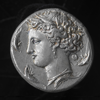

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a coin.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the Syracuse dekadrachm, a remarkable coin from antiquity renowned for its exquisite artistry and high relief, crafted by notable designers like Kimon and Euinatos. This coin has captivated enthusiasts for over 2,500 years, raising questions about how the ancient Greeks achieved such beauty using only hand tools. An interesting connection to American history is found in Theodore Roosevelt, who, while known for his political reforms, also sought to enhance American coinage. Disappointed by the mundane designs of contemporary coins, he envisioned a more artistic approach that would rival the elegance 

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


[RANK0:GPU0] ==> [Batch: 1/6][Data: 2/14] Inference for data_id: 4, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-2.jpg:


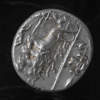

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a coin.
[RANK0:GPU0] ==> Ground truth answer: This exhibit highlights the Syracuse dekadrachm, a stunning ancient coin that exemplifies the artistry of its time, designed by renowned craftsmen such as Kimon and Euinatos. With its striking high relief, this coin has fascinated collectors for more than two millennia, prompting inquiries into the techniques used by the Greeks to achieve such intricate designs without modern tools. A significant figure connected to this coin is Theodore Roosevelt, who, while recognized for his political reform efforts, also sought to elevate the quality of American currency. Frustrated by the lackluster designs of c

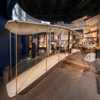

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A full size replica of the Wright brothers first airplane is on display with photos and videos of the brothers flying in the background.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the remarkable 1903 Wright Flyer, the first successful powered airplane, which heralded the beginning of the aerial age. Designed by Wilbur and Orville Wright, this biplane features a 12-horsepower Wright horizontal four-cylinder engine that drives two pusher propellers through a chain-and-sprocket transmission. Notably, it employs linear skids for landing gear and is finished with natural fabric, devoid of any sealant or paint. The Wright brothers' groundbreaking achievement on

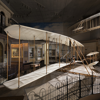

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A collection of old fashioned planes are on display in a museum.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the iconic 1903 Wright Flyer, a pioneering aircraft that marked the dawn of powered flight. Built by the Wright brothers, Wilbur and Orville, this biplane is powered by a 12-horsepower engine that operates two pusher propellers via a sprocket-and-chain system. Its unique landing gear consists of linear skids, and it is covered in natural fabric, without any paint or sealant. The Flyer made its historic first flight on December 17, 1903, in Kitty Hawk, North Carolina, with Orville at the controls for a brief 12-second journey. The W

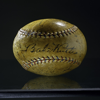

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a ball on the surface.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable autographed baseball from the legendary 1926 New York Yankees, signed by iconic players including Hall of Famers Babe Ruth and Lou Gehrig. Ruth, known for his extraordinary hitting prowess, and Gehrig, celebrated for his record of 2,130 consecutive games played, both left an indelible mark on the sport. Gehrig's battle with amyotrophic lateral sclerosis (ALS), which is often referred to as Lou Gehrig's disease, showcased his incredible humility and resilience, inspiring many during his illness. The baseball, which measures approximately 3 inches in diame

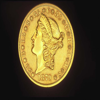

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a coin with some text and numbers on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable coin from the United States Mint in Philadelphia, showcasing a unique design that reflects a significant moment in American numismatic history. The obverse displays the Liberty head facing left, with the date inscribed below and details about weight and fineness surrounding it. The reverse features an eagle, similar to the standard twenty-dollar coin, but replaces the traditional motto "IN GOD WE TRUST" with "DEO EST GLORIA." This coin was part of a series inspired by the desire to enhance the competitiveness of American currency in glo

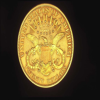

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a coin with a black background.
[RANK0:GPU0] ==> Ground truth answer: This exhibit highlights a significant gold coin minted by the United States Mint in Philadelphia, showcasing both artistic and economic significance. The coin features a Liberty head on the obverse, with the date inscribed below and weight and fineness details surrounding it. On the reverse, an eagle is depicted, but intriguingly, it bears the Latin phrase "DEO EST GLORIA" instead of the more familiar "IN GOD WE TRUST." This design was part of an initiative aimed at improving the international appeal and convertibility of American coins, paralleling the introduction of the fou

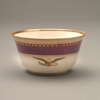

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This small cup has a purple band at the top and a design of an eagle on the front.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features Abraham Lincoln's coffee cup, a poignant artifact from a pivotal moment in American history. This ceramic cup, adorned in purple with white and gold trim, was left behind by President Lincoln on a windowsill at the White House on the evening of April 14, 1865, just before he attended Ford's Theatre. A White House servant preserved this cup as a memento of that tragic night, which marked the end of Lincoln's life and the Civil War. In 1887, Captain D.W. Taylor gifted it to Robert Todd Lincoln, the president's eldest son, ensuring its 

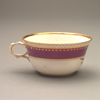

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This cup has a handle and is purple next to the gold.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a significant artifact: Abraham Lincoln's coffee cup, which dates back to 1887. The cup was a gift from Captain D.W. Taylor to Robert Todd Lincoln, the president's eldest son. It holds a somber history, as it was left behind by Lincoln on April 14, 1865, just before he went to Ford's Theatre for what would be his final evening. A White House servant preserved the cup, recognizing its importance as a relic of that fateful night. Crafted from ceramic and featuring a striking purple color with white and gold trim, the cup measures approximatel

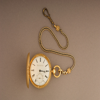

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A watch with a gold chain is on a gray surface.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable English gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite timepiece served as a notable emblem of his achievements as a lawyer. The watch's movement, crafted in Liverpool, represents the high-quality manufacturing of the era, while the case was made by an unidentified American artisan. Notably, this watch boasts one of the finest movements available in England, capable of maintaining accurate time to within seconds daily. A hidden n

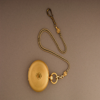

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: Gold watch with a chain that is 23 inches long.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases Abraham Lincoln's gold pocket watch, acquired in the 1850s from a jeweler named George Chatterton in Springfield, Illinois. Although Lincoln was not typically seen as vain, the watch symbolized his professional success as a lawyer. The watch's movement was produced in Liverpool, a hub for watchmaking at the time, while the case was crafted by an unidentified American shop. Known for its exceptional quality, the watch's movement can keep time within seconds daily. A fascinating aspect of this piece is the hidden message engraved by watchmaker Jona

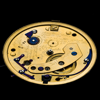

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a watch.
[RANK0:GPU0] ==> Ground truth answer: This display features an exquisite gold pocket watch that once belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a prestigious symbol of his accomplishments as a lawyer. The watch's movement was manufactured in Liverpool, a center of watch production, and it is accompanied by a high-quality case made in America. Remarkably, this timepiece has a movement capable of keeping time to within seconds each day. An intriguing story lies within, as 

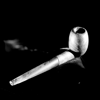

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image I can see a pipe on the table.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features Albert Einstein's iconic pipe, dating back to around 1948. Known for his groundbreaking contributions to theoretical physics, including the theory of relativity, Einstein is also recognized for his distinctive appearance, which prominently included this pipe. Despite reducing his smoking due to medical advice in his later years, he cherished the physical sensation of holding a pipe. This particular pipe shows signs of extensive use, with a noticeable hole worn into its bit. It was gifted to Gina Plunguian, a close friend and admirer of Einstein, before being acquired by 

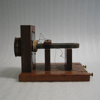

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a device that produces an electric current.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the National Museum of American History highlights the groundbreaking invention of the telephone by Alexander Graham Bell. On March 7, 1876, Bell was awarded the first patent for an apparatus designed to transmit vocal sounds telegraphically. Just three days later, he successfully communicated with his assistant, Thomas Watson, uttering the iconic words, “Mr. Watson, come here, I want to see you.” Featured in this exhibit is one of the original telephones used during a demonstration between Boston and Salem, Massachusetts, on November 26, 1876. This particular device i

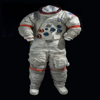

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a picture of a mannequin wearing a space suit.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the Apollo 17 spacesuit, which was worn during the final Apollo mission that successfully landed astronauts on the moon in 1972. Launched on December 7, 1972, aboard a Saturn V rocket, Apollo 17 included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, notable for being the only geologist to have walked on lunar soil. While Evans orbited the moon, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region, where they conducted extensive scientific activities over three days. They comple

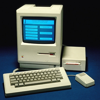

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: The computer has a blue screen with several windows on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the iconic Apple "Classic" Macintosh Personal Computer, launched in 1984 by Apple Inc. This groundbreaking machine introduced a graphic user interface (GUI) to the world of personal computing, a concept that had its roots in the 1970s at Xerox's Palo Alto Research Center. Apple captured public attention with a memorable Super Bowl XVIII advertisement, marking the Macintosh's debut on January 22, 1984, with a retail price of approximately $2,500. Unlike previous computers that relied on command lines, the Macintosh allowed users to interact with programs th

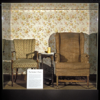

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a glass box. In this box there are two chairs. On this table there is a cup.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features an iconic upholstered wing chair that was prominently used by the character Archie Bunker, portrayed by Carroll O'Connor, in the groundbreaking television series "All in the Family." The chair, with its distinctive orange-yellow woven fabric and sturdy wooden frame, dates back to the 1940s, although its exact origins remain unclear. Initially acquired from a thrift store in Southern California, it served as a significant prop throughout the show's run from 1971 to 1979, until it was replaced by a reproduction in the final season a

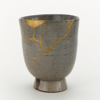

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This bowl is part of the collection of the Asian Art Museum of San Francisco. It is made of stoneware and is grey in color. There are gold lines on the bowl.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable 17th-century tea bowl from the Satsuma ware collection, specifically the White Satsuma type, hailing from Kagoshima prefecture in Japan during the Edo period. The bowl, made of stoneware and finished with a clear, crackled glaze, has a storied past, having been broken and subsequently repaired using the traditional Japanese art of kintsugi, or golden joinery. This technique not only mends the bowl but also accentuates its history by highlighting 

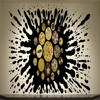

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting.
[RANK0:GPU0] ==> Ground truth answer: This exhibition features the captivating work of Yinka Shonibare, a prominent artist born in London in 1962. The display showcases 25 circular canvases of varying sizes, meticulously arranged over a large-scale ink splatter pattern that has been applied using a template. Each canvas is adorned with intricate foliate designs painted in black and gold, utilizing Dutch wax printed fabrics. Shonibare's earlier works are characterized by small square canvases in a grid layout, while his more recent pieces, including this one, challenge traditional boundaries with their dynamic black splatter forms. The artwork draws insp

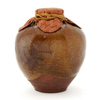

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a brown vase with a brown and red design on it.
[RANK0:GPU0] ==> Ground truth answer: The exhibit titled "Chigusa and the Art of Tea," located at the Arthur M. Sackler Gallery, delves into the intricate relationship between Japanese tea culture and the art of collecting. It highlights how collectors engaged with tea-leaf storage jars through the traditional tea ceremony, known as chanoyu, by bestowing names and adorning these jars with exquisite textiles. Central to this theme is the jar named Chigusa, which evolved from a simple Chinese import into a revered object of beauty and contemplation, while still retaining its functional purpose. Notably, 16th-century tea

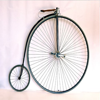

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A penny farthing bicycle is on display.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the National Museum of American History celebrates the arrival of spring with a spotlight on an original 1886 Columbia Light Roadster high-wheel bicycle. This remarkable artifact, which originally sold for around $135, was produced by the Pope Manufacturing Co., recognized as the first bicycle manufacturer in the United States. The bicycle features a distinctive configuration with a 53-inch front wheel, supported by 60 spokes, and an 18-inch rear wheel with 20 spokes, available in a range of sizes for riders. Accompanying this bicycle is a historic photograph showcasing one of Ame

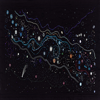

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting. In this painting, we can see some objects.
[RANK0:GPU0] ==> Ground truth answer: The exhibit titled “Milky Way, Starry Night # 2” features the work of Gwich'in artist Margaret Nazon, who hails from Tsiigehtchic in the Northwest Territories of Canada. Created in 2021, this piece reflects Nazon's lifelong fascination with the stars, a passion that she fully embraced in her art later in life after being inspired by Hubble Space Telescope imagery. Nazon's work is distinctive as it incorporates swirling galaxies, a departure from traditional Gwich'in beadwork, showcasing her unique artistic style. This artwork is part of the “Lights Out: Recovering Our Night

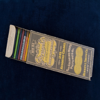

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a picture of a box which contains crayons.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights a pack of Crayola Crayons from 1903, celebrating a beloved back-to-school tradition. Invented by cousins Edwin Binney and C. Harold Smith, the crayons were crafted using paraffin wax and nontoxic pigments, making them safe and durable for young artists. The name "Crayola," created by Alice Binney, combines the French word for chalk, "craie," with "oleaginous," referring to its waxy texture. This particular set, aimed at budding artists, features 28 vibrant colors, including celestial blue and rose pink, an

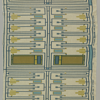

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a poster. In this poster we can see some text and some designs.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a striking piece designed by the renowned American architect Frank Lloyd Wright, who lived from 1867 to 1959. The textile, produced by F. Schumacher & Co., a New York-based manufacturer established in 1889, showcases a captivating geometric pattern composed of rectangular blocks in shades of light blue and various olive tones, intricately connected by fine lines of darker blue against an off-white backdrop. The length of the printed linen measures 120 by 57.5 cm (47 1/4 by 22 5/8 inches), with a repeat height of 63.5 cm (25 inches). Additional

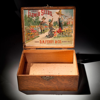

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a wooden box with a painting on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features an antique seed box from the late 19th century, specifically from the renowned D.M. Ferry & Co., and is part of the Smithsonian's celebration of National Garden Month. In the 1800s, seed packets were commonly stored in decorative wooden boxes that showcased vibrant labels from seed companies, serving as effective marketing tools on general store counters. This particular seed box, which showcases the D.M. Ferry & Co. label, is significant for its association with the invention of the “commission box,” a display rack that revolutionized retail presentation. Acquired by th

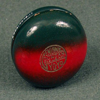

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A red and black item is marked with the words Gunning YoYo.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights the captivating story of the yo-yo, a toy that gained immense popularity in America thanks to Chicago businessman Donald F. Duncan Sr. In 1928, Duncan discovered the yo-yo during a business trip to San Francisco, where it was being sold by Pedro Flores, a Filipino immigrant. Flores had begun manufacturing the toy, which he named “yo-yo,” meaning “come-come” in Tagalog. By early 1929, he had established his own company and produced over 100,000 wooden yo-yos, recognizing the need for demonstrations

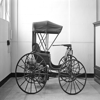

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a black and white image. In this image we can see a vehicle on the floor. In the background we can see a wall and a window.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the 1893-94 Duryea automobile, recognized as one of the earliest American-made vehicles. On September 21, 1893, Frank Duryea conducted a road test of this innovative automobile, which was essentially a second-hand carriage outfitted with a gasoline engine, in Springfield, Massachusetts. In 1896, Frank and his brother Charles, along with financial partners, established the Duryea Motor Wagon Company, marking it as the first American enterprise to manufacture and sell automobiles. This p

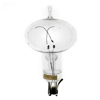

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a bulb.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the Edison Light Bulb, which dates back to 1879 and represents a pivotal moment in the history of innovation. Thomas Edison utilized this carbon-filament bulb during the inaugural public demonstration of his groundbreaking invention—the light bulb, recognized as the first viable electric incandescent lamp. The mechanism of the bulb involves an electrical current flowing through a metal filament wire, which heats up to an intense temperature, ultimately producing light. To safeguard the hot filament from oxygen, the bulb is encased in glass filled with inert gas. This significant demonstration took

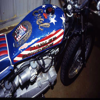

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A harley davidson motorcycle with an american flag paint job.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History showcases Evel Knievel's iconic 1972 Harley-Davidson XR-750, a motorcycle synonymous with the legendary daredevil's thrilling performances. Evel Knievel, born Robert Craig Knievel, captivated audiences with his death-defying stunts, which often resulted in numerous injuries, including 35 to 40 broken bones throughout his career. His televised daredevil shows, beginning in 1965, featured spectacular jumps over rows of vehicles, including cars, trucks, and buses. The XR-750, constructed from steel, aluminum,

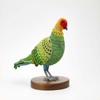

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a toy of a bird.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features Laurel Roth Hope's intriguing work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This piece cleverly employs humor to highlight the grave issue of species extinction. Through her “Biodiversity Reclamation Suits,” Hope enables common rock pigeons to don the guise of extinct North American birds, symbolically addressing the loss of biodiversity. Utilizing traditional crafting techniques such as carving, embroidery, crochet, and collage, she transforms everyday materials into striking animal sculptures that evok

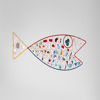

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting of a fish.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features "Fish," a captivating work by renowned artist Alexander Calder, created in 1945 and housed at the Hirshhorn Museum and Sculpture Garden in Washington, D.C. Calder, who was born into a family of artists and initially trained as a mechanical engineer, transitioned to art after working as a freelance illustrator. His journey took him to Paris, where he became inspired by avant-garde movements and began crafting his signature wire sculptures, often referred to as “drawings in space.” Influenced by the minimalist aesthetic of Piet Mondrian, Calder pioneered the concept of “mobiles” in 1931

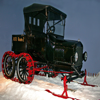

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a black color vehicle on the snow.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a 1921 Ford Model T equipped with a unique snow attachment, highlighting the ingenuity of early 20th-century rural mail carriers. As these carriers transitioned from horse-drawn sleds to automobiles, they faced challenges navigating deep snow. In response, Virgil White innovated by converting cars into snowmobiles, replacing front tires with skis and rear tires with caterpillar treads. His invention, dubbed the Snowbird, provided a cost-effective solution for winter deliveries, eliminating the need for horses. Initially, White'

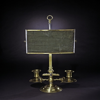

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image I can see a stand and on it I can see two candles. I can also see this image is little bit in dark.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a significant artifact linked to George Washington, specifically a brass candle stand believed to have been used by him while composing his Farewell Address in 1796. After serving two terms as president, Washington chose to retire to Mount Vernon, where he penned his final thoughts for the nation, urging unity among Americans amidst emerging political factions. His Farewell Address was first published in The American Daily Advertiser and has since been commemorated annually by the United States Senate

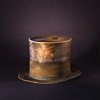

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a hat.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features President Abraham Lincoln's iconic top hat, housed at the Smithsonian's National Museum of American History. Acquired from Washington hat maker J.Y. Davis, this hat stands as a symbol of Lincoln's stature, both physically at 6'4” and in his leadership. Notably, a black silk mourning band adorns the hat, honoring the memory of his son Willie, who passed away in 1862. While the exact date of acquisition remains unknown, the hat was last worn by Lincoln on the fateful night of April 14, 1865, as he headed to Ford's Theatre. Following Lincoln's assassination, the War Department safeguarded the hat along

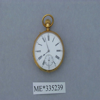

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A pocket watch with roman numerals is displayed above a label that says ME*335239.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History features a remarkable timepiece belonging to Helen Keller, who was born on June 27, 1880. Keller, a pivotal figure in advocating for women's suffrage and workers' rights, faced significant challenges after losing her sight and hearing due to illness at a young age. Her breakthrough came with the help of Anne Sullivan, who taught her to communicate. The Swiss-made "touch watch," gifted to Keller by John Hitz in 1892, is designed with pins around its edge to indicate the hours, allowing 

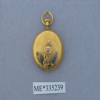

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A gold watch is on display above a label that says ME*335239.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases an extraordinary pocket watch that once belonged to Helen Keller, who was born on June 27, 1880. Keller, known for her advocacy for women's rights and disability rights, faced immense challenges after becoming deaf and blind at a young age. Her life changed dramatically when she met Anne Sullivan, who taught her to communicate. The watch, presented to Keller by John Hitz in 1892, features a unique design with pins around the case that allow the wearer to feel the time, making it particularly suitable for someone who could not see. K

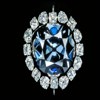

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a diamond pendant.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a stunning diamond necklace crafted by Cartier, Inc., showcasing a primary gem that weighs an impressive 45.52 carats. The diamond, characterized by its dark gray-blue hue, is cut in a modified antique cushion style, which enhances its unique visual appeal. Originating from India, this exquisite piece is part of the Mineral Sciences collection, specifically within the Gems category at the National Museum of Natural History. The necklace is cataloged under the USNM number NMNH G3551-00 and is a singular specimen in this exhibit, last modified on September 26, 2022. For more detailed infor

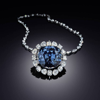

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This necklace contains the largest blue diamond in the world.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a remarkable diamond necklace by Cartier, Inc., featuring a single primary gem that weighs 45.52 carats. The diamond is distinguished by its dark gray-blue color and is elegantly cut in a modified antique cushion shape, which adds to its vintage charm. Sourced from India, this necklace is a highlight of the Mineral Sciences collection at the National Museum of Natural History, categorized under Gems. The record for this exquisite piece is identified as NMNH G3551-00 and was last updated on September 26, 2022. For further details, yo

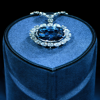

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a necklace on the blue color cloth.
[RANK0:GPU0] ==> Ground truth answer: On display is a captivating diamond necklace by Cartier, Inc., featuring a single, striking primary gem that weighs 45.52 carats. This diamond exhibits a dark gray-blue coloration and is expertly cut in a modified antique cushion style, making it a true work of art. The necklace hails from India and is part of the Mineral Sciences department's Gems collection at the National Museum of Natural History. It is cataloged under the USNM number NMNH G3551-00, with the last modification recorded on September 26, 2022. For more in

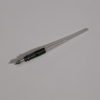

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a pen.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features an Esterbrook pen that holds significant historical importance as it was used by President Lyndon B. Johnson to sign the Civil Rights Act of 1964 on July 2 of that year. Part of the Smithsonian's National Museum of African American History and Culture collection, this particular pen was among over 70 identical pens distributed to key figures in the Civil Rights Movement. The journey to the enactment of this landmark legislation was fraught with challenges, initially introduced by President John F. Kennedy before his tragic assassination in November 1963. The bill's fate then rested with President Jo

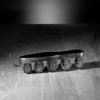

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a toy on the surface.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the Volito, an innovative inline skate crafted in 1823 by Robert John Tyers. As athletes prepare for the 2014 Winter Olympics, it's intriguing to consider how skaters of the 19th century maintained their skills without the luxury of indoor rinks. The Volito is distinguished by its wooden sole, a single row of five wooden wheels, and a unique curved iron bar at the front, which functioned as a basic brake. What truly set this skate apart was its unequal wheel sizes—larger in the center and smaller at the ends—allowing skaters to navigate turns with greater ease. This r

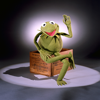

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a toy of a frog.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases Kermit the Frog, a beloved character created by Jim Henson, who has become an iconic figure in children's television. Kermit, a vibrant green puppet, first appeared in 1955 on the show "Sam and Friends" and has since been the star of "The Muppet Show" and a regular on "Sesame Street." Known for his calm demeanor amidst chaos, Kermit is famous for his poignant song “Bein' Green,” which reflects on the challenges of his color while ultimately celebrating his identity. The puppet is crafted from various materials, including synthetic fiber, felt, and plastic, and measures approximately 27 in

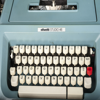

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A blue, Olivetti Studio 46, typewriter with a single red key.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the typewriter of Octavia Estelle Butler (1947–2006), a celebrated author in the realm of science fiction. Butler is renowned for her impactful works, including the five-volume Patternist series, the Xenogenesis trilogy—also known as Lilith's Brood—and the thought-provoking novels Parable of the Sower and Parable of the Talents, along with her acclaimed short story collection, Bloodchild and Other Stories. Her writing uniquely blended elements of African American history with speculative futures and alien psychology, establishing a g

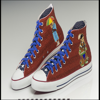

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: These are the shoes which are in red color.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable piece titled "Kiowa Ah-Day," created by Kiowa artist Teri Greeves in 2004. The artwork, which takes the form of sneakers, is a unique blend of traditional and contemporary materials, incorporating cotton canvas, glass beads, and commercial rubber. Measuring 33 x 11 x 15 cm, this piece exemplifies Greeves' innovative approach, showcasing overlay beadwork that reflects the rich cultural heritage of the Kiowa people. Acquired by the National Museum of the American Indian from Thirteen Moons Gallery in Santa Fe, New Mexico, this work is part of a broader collect

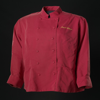

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a red color jacket.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a significant collection from the Smithsonian's National Museum of African American History and Culture, featuring a gift from Dooky Chase's Restaurant and renowned Chef Leah Chase. Celebrated for her assertion that “we changed the world over a bowl of gumbo,” Chase played a pivotal role in the civil rights movement by hosting strategy meetings at her restaurant. Known as "The Queen of Creole Cuisine," she elevated New Orleans Creole cooking to global prominence. Alongside her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop established by her mothe

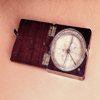

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a compass.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a remarkable silver-plated pocket compass that dates back to around 1804, purchased by Meriwether Lewis in preparation for the historic Lewis and Clark Expedition. Crafted by Philadelphia instrument maker Thomas Whitney, the compass features a mahogany box, a brass rim graduated in degrees, a paper dial, and two brass sight vanes, all housed in a leather carrying case. While it remains uncertain whether Lewis intended the compass for himself or as a gift for his expedition partner, William Clark, it served as a vital navigational tool during their journey. Under President Thomas Jefferson's dir

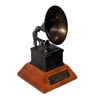

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a trophy.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases Bob Newhart's 1960 Grammy Award, a significant artifact from the celebrated comedian's illustrious career. Born on September 5, 1929, in Oak Park, Illinois, Newhart has entertained audiences for over sixty years with his signature deadpan style, cleverly critiquing social norms and the absurdities of American life. His groundbreaking comedy album, The Button-Down Mind of Bob Newhart, made history by becoming the first comedy LP to reach No. 1 on the Billboard charts and won him a Grammy for Album of the Year, making him the only comedian to win a Grammy for Best New Artist. Newhart's influence e

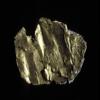

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a gold leaf.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable gold nugget from 1848, housed at the Smithsonian's National Museum of American History. Regarded as the first gold piece discovered at Sutter's Mill in California, this nugget played a pivotal role in sparking the infamous gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall noticed a glimmer in the water and retrieved what he identified as a thin scale of pure gold. Following this discovery, Marshall presented the scale to Capt. Joseph L. Folsom, who documented it as the first gold found in Northern California. By August of that year, thi

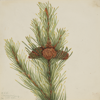

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting. In this painting, we can see a plant with some fruits.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the exquisite watercolor work of Mary Vaux Walcott, particularly her piece titled "Lodgepole Pine (Pinus Contorta murrayana)" created in 1921. Measuring 10 x 7 inches, this artwork is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's journey into botanical illustration began when a botanist encouraged her to paint a rare blooming arnica. Her marriage to Charles Doolittle Walcott, the Smithsonian's Secretary, in 1914 led to summers spent in the Canadian Rockies, where she produced hundreds of 

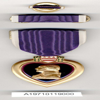

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A Purple Heart is shown with a bronze star and a blue ribbon.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the esteemed United States Purple Heart, a distinguished military decoration awarded to those wounded or killed while serving in the U.S. armed forces. The medal is crafted in a striking gold heart shape, showcasing a profile relief of George Washington at its center, set against a rich purple enamel background. Above Washington's bust, the medal is adorned with a shield displaying his family coat of arms. The reverse side bears the embossed inscription "FOR MILITARY MERIT," highlighting the medal's significance. It is suspended from a silk purple ribbo

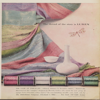

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a poster. On the poster there is a cloth. Also there is a vase. And there are threads. Also there is some text.
[RANK0:GPU0] ==> Ground truth answer: This exhibit, titled "The Thread of the Story Is Lurex: The Look of Porcelain," showcases the work of renowned American textile designer Dorothy Liebes, who significantly influenced various design disciplines from the 1930s to the 1960s. Known for her vibrant colors and rich textures, Liebes developed a distinctive style that became synonymous with the modern American aesthetic, referred to as the “Liebes Look.” Her collaborations with notable architects and designers, such as Frank Lloyd Wright and R

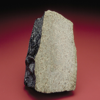

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a large rock that is textured and colored unevenly.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a fragment of the Nakhla meteorite, which is significant as one of the thirty-four meteorites believed to have originated from Mars. The Nakhla meteorite fell to Earth on June 28, 1911, around 9 a.m. in Alexandria, Egypt, where it was observed exploding in the atmosphere before landing in approximately 40 pieces, weighing a total of 22 pounds. These fragments were found buried up to a meter deep in the ground. The Smithsonian acquired two samples shortly after the fall, and in 1962, it added a 480-gram piece to its collection, totaling 650 grams of Nakhla

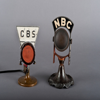

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: Two old fashioned microphones with one saying CBS and one saying NBC.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a significant artifact from the era of President Franklin D. Roosevelt's "Fireside Chats," a series of informal radio addresses he delivered to the American public starting on March 12, 1933. With the nation grappling with the Great Depression, Roosevelt's ability to communicate directly with citizens through radio became a vital tool for shaping public opinion and providing reassurance. The exhibit highlights an RCA Type 50-A microphone, adorned with the National Broadcasting Company logos, which was used during these broadcasts. Acquired by th

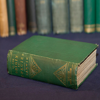

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A green book with gold lettering sits in front of many other books.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases "On the Origin of Species" by Charles Darwin, published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the May 11, 1820, anniversary of the HMS Beagle's launch, the vessel that carried Darwin on his pivotal scientific journey. The Beagle was launched from the Woolwich Dockyard in London and underwent several adaptations before embarking on its second survey voyage on December 27, 1831. Darwin, a young naturalist, joined the crew to provide geological insights, and his extensive research during the five-y

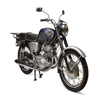

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a picture of a motor bike.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features Robert M. Pirsig's iconic 1966 Honda Super Hawk motorcycle, prominently showcased at the Smithsonian's National Museum of American History. This motorcycle is not just a vehicle; it is a symbol of the philosophical journey outlined in Pirsig's influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Published in 1974, the book quickly became a bestseller, selling over a million copies within its first year and igniting a cultural movement that encouraged individuals to reevaluate their relationship with technology and seek a harmonious existence. The

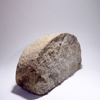

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a rock.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the Plymouth Rock Piece, a significant artifact housed at the National Museum of American History, which is believed to be linked to the landing of the Mayflower Pilgrims in 1620. According to tradition, this rock marks the site where William Bradford and his fellow settlers first arrived in Plymouth, Massachusetts. Bradford, who played a pivotal role as a leader and governor of the Plymouth Colony, is also credited with the establishment of Thanksgiving as it is celebrated in the United States today. The rock has a storied past, having been relocated in 1774 from its original position to the town s

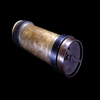

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a cylindrical object.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a Pneumatic Mail Container from 1953, a fascinating relic of a bygone era when cities utilized pneumatic tube systems for mail delivery. Originating in the late 1890s, these systems were ingeniously designed to transport mail through underground tubes, with each canister capable of holding up to 500 letters. The canisters, or carriers, were propelled by compressed air, allowing them to travel at speeds averaging 35 miles per hour. At the height of their operation, these systems facilitated the movement of an astounding 6 mi

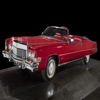

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image I can see a red colour car on the black colour surface.
[RANK0:GPU0] ==> Ground truth answer: The "Rock 'n' Roll Ride" exhibit at the Smithsonian's National Museum of African American History and Culture showcases a remarkable piece of musical history: Chuck Berry's striking red 1973 Cadillac Eldorado. This vehicle is prominently featured in the museum's "Musical Crossroads" exhibition. The Cadillac was a cherished part of Berry's personal collection and gained fame during the filming of the 1987 documentary "Hail! Hail! Rock 'n' Roll," directed by Taylor Hackford. The film captures the essence of two concerts held in 1986 to honor Berry's 60th birthday, and 

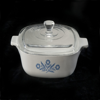

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: White pot with a blue flower design by pyrex.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a quintessential kitchen item often associated with holiday gatherings—a white casserole dish made by CorningWare in 1965. Adorned with the iconic blue cornflower motif, this dish represents a blend of innovation and tradition. Originally created for military use during World War II, CorningWare's Pyroceram material later emerged as an ideal choice for bakeware, thanks to its ability to endure rapid temperature shifts and resist stains and odors. Its versatility allowed it to transition seamlessly from cooking to freezing to serving, making it a bel

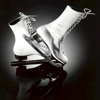

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a pair of skates on the surface.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the autographed ice skates of Sonja Henie, a pioneering figure in women's figure skating, dating back to around 1945. Henie, a Norwegian skater, revolutionized the sport in the late 1920s and 1930s by introducing white leather skates, a significant departure from the traditional black skates. Her enchanting performances earned her the first of ten consecutive world titles in 1927, where she captivated audiences with her innovative dance style. Henie's influence extended beyond the rink; she was the first to blend choreography with figure skating and popular

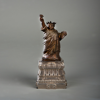

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a statue of liberty.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features one of the earliest models of the Statue of Liberty, often referred to as the American Committee Model. Crafted in the United States, this statuette was produced in large quantities, with tens of thousands sold to raise funds for the construction of the statue's pedestal in New York Harbor. The design, created by French sculptor Frédéric-Auguste Bartholdi, was made available in both six-inch and twelve-inch sizes, with a national newspaper campaign promoting them at one dollar and five dollars respectively. Richard Butler, a rubber manufacturer from New York, led the American Committee

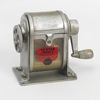

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a machine.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the Dexter Model 3 Pencil Sharpener, crafted around 1920 by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. This charming artifact, made from metal, cellulose, and painted wood, measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). A gift from Lucy Commoner, it holds a significant place in the Cooper Hewitt, Smithsonian Design Museum collection, although it is not currently on display. As the back-to-school season approaches, this sharpener evokes nostalgia for many, reminiscent of countless school days. The Dexter Model 3 was an evolution of earlier 

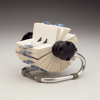

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A round item with cards on it including one that says CARD FILE.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the iconic Rolodex Open Rotary Card File, a quintessential office supply that revolutionized the way people organized their business contacts before the advent of digital technology. Manufactured by the Rolodex Corporation in the USA, this particular model is crafted from bent tubular metal, molded plastic, rubber, and paper, measuring 18 x 18 x 16.5 cm. The Rolodex operates on a cylindrical design, allowing users to easily flip through A-Z index cards to find contact information. Despite the rise of smartphones and computers, the

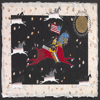

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a painting.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the "Lakota Horse Mask," created in 2008 by Jim Yellowhawk, a member of the Cheyenne River Lakota tribe. This striking piece, which utilizes acrylic on paper and gold leaf, symbolizes the profound relationship between American Indians and horses, which many tribes refer to as the Horse Nation. Horses were not only allies in times of peace but also played a vital role during conflicts, deeply influencing the cultural landscape of various tribes. Interestingly, horses first emerged in the Americas over 40 million years ago, later becoming extinct before being reintroduced by Colum

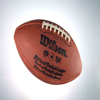

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a football.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the iconic Wilson Duke football, which has been the official ball of the Super Bowl since Super Bowl II in 1968. The football on display was specifically used during Super Bowl XIV, held at the Rose Bowl in Pasadena, California, on January 20, 1980. In this thrilling game, the Pittsburgh Steelers triumphed over the Los Angeles Rams with a score of 31-19, marking the Steelers' fourth Super Bowl victory. Notably, it was also the second consecutive year that quarterback Terry Bradshaw earned the Most Valuable Player award. The Wilson Duke football, known for its premium leather an

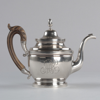

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a silver teapot with a monogram of AH engraved on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable silver teapot created by American artisan Peter Bentzon, dating from approximately 1817 to 1829. The teapot showcases an elegant oval vase shape, supported by a spreading pedestal foot. Its design includes a gracefully curved spout, which is topped with an incised patera, and a scroll handle adorned with wooden leaf caps. The hinged domed lid is finished with an acorn finial, adding to its aesthetic appeal. Notably, the piece bears the scripted monogram "MC" engraved on its side, alongside the name "Rebecca Dawson" inscribed along the botto

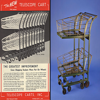

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a poster. On the left side there is a picture of a trolley. On the right side there is a picture of a trolley.
[RANK0:GPU0] ==> Ground truth answer: The exhibit at the National Museum of American History features the innovative Telescoping Shopping Cart, designed by Orla E. Watson in 1946. This clever invention, first introduced in 1947 at Floyd's Super Market in Kansas City, Missouri, revolutionized the way consumers shop by allowing carts to nest together for efficient storage. Watson asserted that these new carts utilized only one-fifth of the space of traditional carts when parked, making them a practical solution for busy shoppers. This display is part of the 

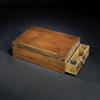

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a wooden box with two drawers.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the portable writing desk designed by Thomas Jefferson, which he used to draft the Declaration of Independence in 1776. The desk features a hinged writing board and a locking drawer for storing essential writing materials such as papers, pens, and an inkwell. During the summer of 1776, as members of the Second Continental Congress prepared to declare independence from Great Britain, Jefferson, a Virginia delegate, was tasked with drafting this pivotal document. He later noted that the declaration was meant to reflect the collective American sentiment rather than being an ori

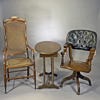

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: There are three chairs. The chair on the left has a high back and is padded. The chair in the middle has a round table. The chair on the right has a high back and a round table.
[RANK0:GPU0] ==> Ground truth answer: This exhibit focuses on a pivotal moment in American history, specifically the surrender of the Confederate Army at Appomattox Court House on April 9, 1865. It showcases the chair used by General Ulysses S. Grant during his negotiations with General Robert E. Lee, marking the effective conclusion of the Civil War. The exhibit highlights how Grant, seated in this chair, drafted and signed the surrender terms, a significant act that symbolized the end of hostilit

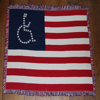

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: On the floor is a blanket with the American flag on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a unique lap blanket that has been hand-altered to incorporate the universal access symbol, represented by stitched stars, reflecting the ideals of freedom and independence associated with the American flag. Created by advocates from the American Disabled for Attendant Programs Today (ADAPT), this piece signifies the ongoing struggle for civil rights among individuals with disabilities. Founded in 1983 in Denver, ADAPT emerged from the disability rights movement, which gained momentum after World War II as individuals with disabilities formed communities and 

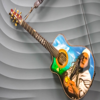

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A guitar is against a wall with the word Vive painted on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the guitar of Carlos Vives, a renowned Colombian singer and Grammy Award winner celebrated for his contributions to the vallenato music genre. Vallenato, originating from Colombia's Atlantic coast, blends European instruments like the accordion with rich, poetic lyrics and the traditional rhythms of the Arhuaco indigenous people. Historically, vallenato was performed by rural workers and cowboys, remaining largely within local communities until its revitalization in the 1990s by artists like Vives, who infused it with pop and rock elements. This transfo

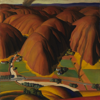

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting. In this image we can see hills, trees, houses, road, grass and sky.
[RANK0:GPU0] ==> Ground truth answer: This exhibition features a captivating painting by Ross Dickinson, a talented artist who thrived during the Great Depression. Created while he was part of the Public Works of Art Project, the artwork vividly portrays California's Central Valley, showcasing lush green fields alongside a small river, all framed by stark, arid hills. The scene evokes the promised land sought by many families fleeing the Dust Bowl, yet Dickinson introduces an unsettling element—a small controlled fire in the foreground and a larger plume of smoke rising from the distant

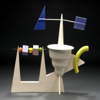

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a sculpture.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the imaginative work of artist Peter Shire, born in Los Angeles in 1947. Notably, Shire's teapots, particularly the Weathervane Teapot, are vibrant constructions made from clay slabs, showcasing a playful arrangement of three-dimensional squares, balls, squiggly rods, and hollow tubes. Shire aimed to challenge conventional notions of "tea-time," making it an experience that is inclusive and accessible to everyone. The design of this teapot invites interaction, prompting viewers to ponder how to hold it for pouring, or whether it is even functional as a teapot. After 1985, Shire shifted his foc

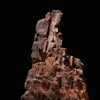

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a wooden object.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the Spotsylvania tree stump, a poignant relic from the Civil War, dating back to 1864–65, located at the Smithsonian's National Museum of American History. This tree, once a majestic oak, stood in a serene meadow near Spotsylvania Court House, Virginia, until May 12, 1864, when it became a silent witness to the brutal conflict between Confederate forces and the Union's Second Corps. The area, now known as the Bloody Angle, transformed dramatically over the course of a single day, as the fierce combat led to approximately 31,000 casualties. The tree stump bears the scars of 

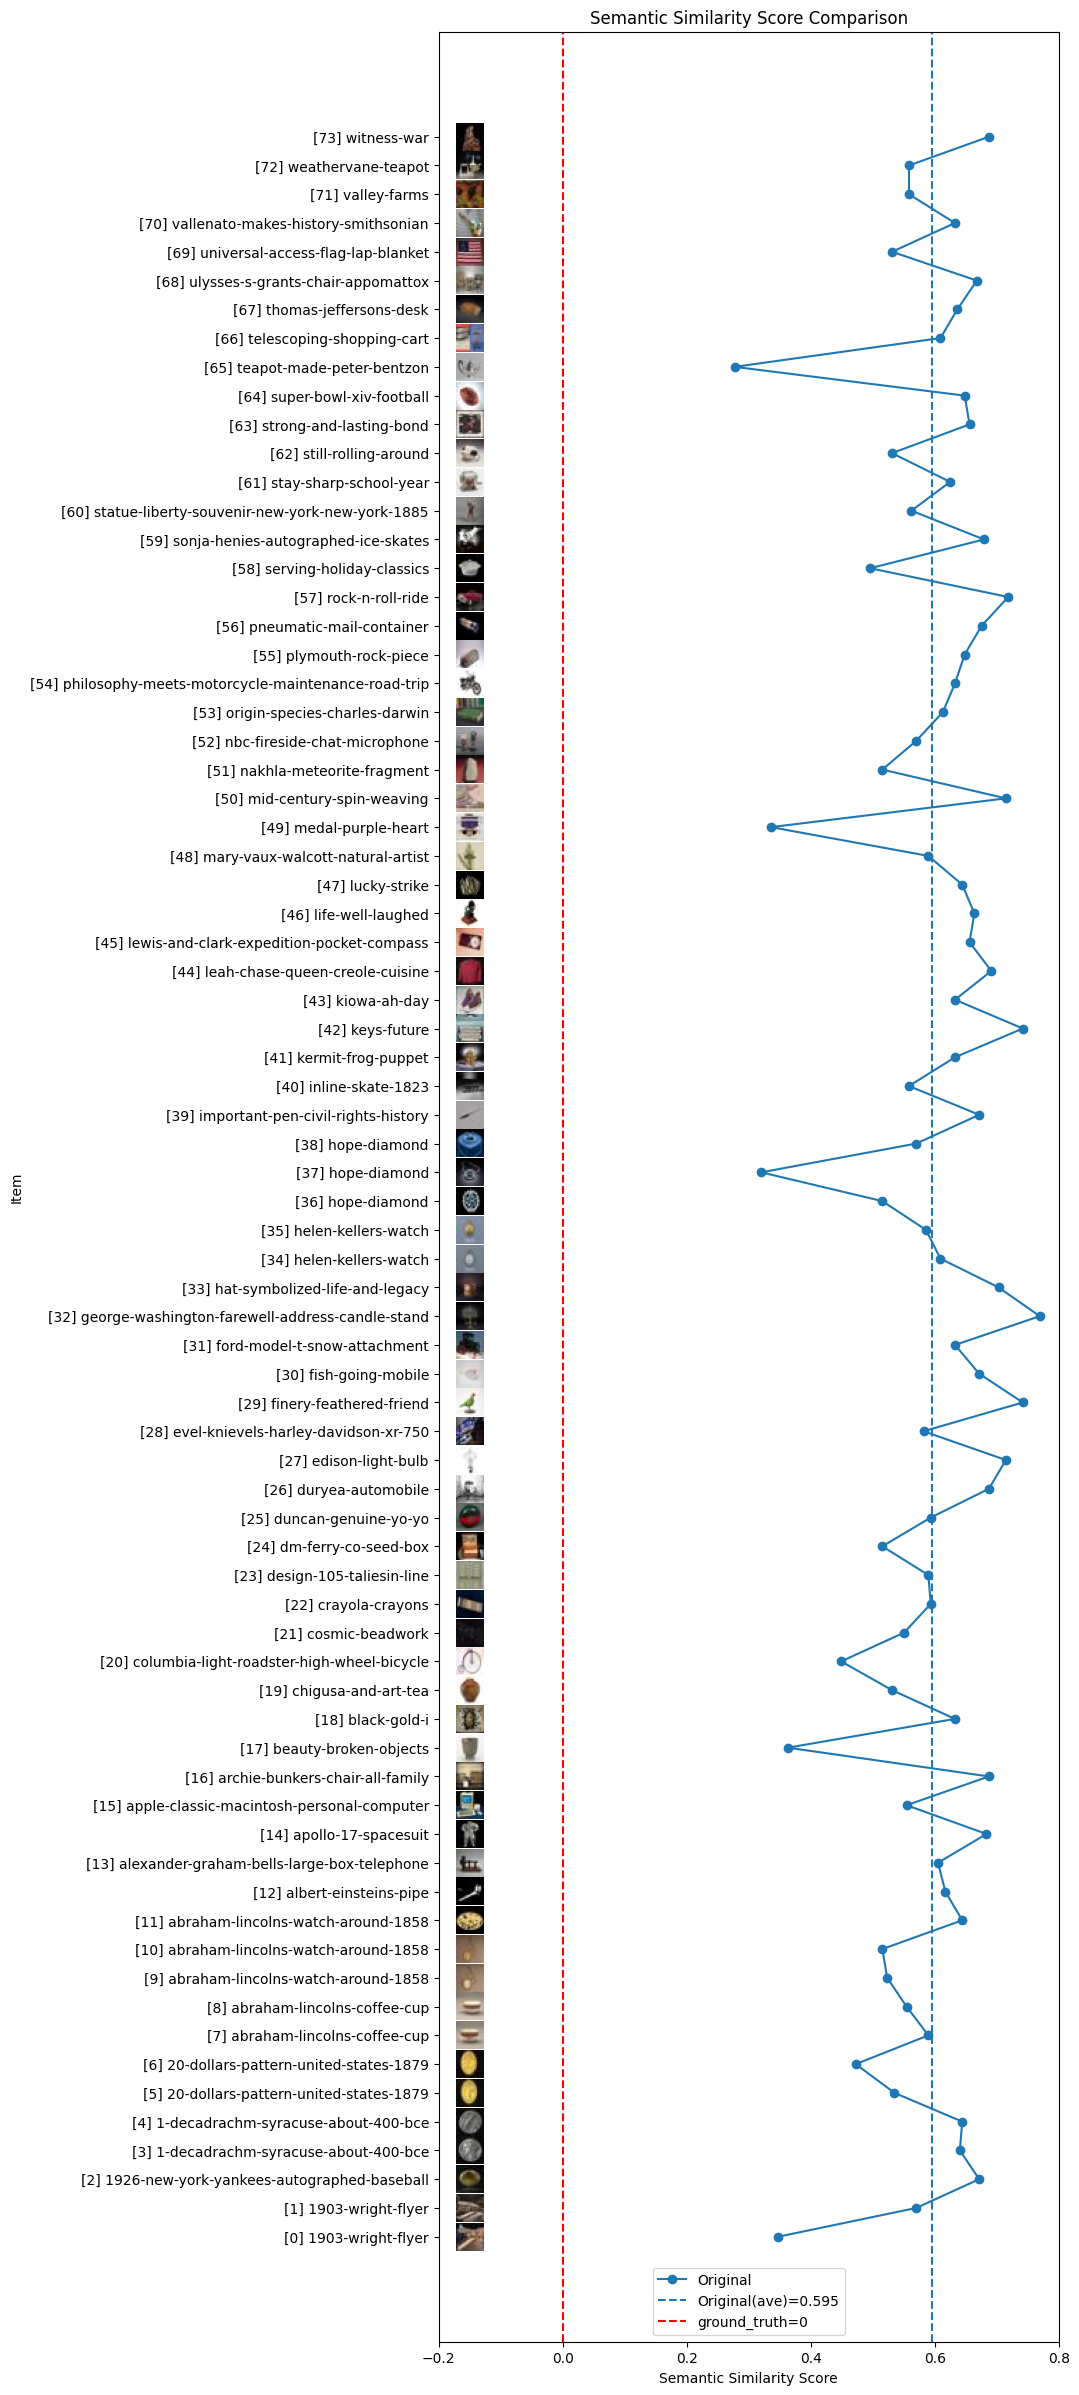

[RANK0:GPU0] ==> Setting up pad token (<pad>) in processor...[RANK1:GPU1] ==> Setting up pad token (<pad>) in processor...

[RANK0:GPU0] ==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>[RANK1:GPU1] ==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>

[RANK1:GPU1] ==> Adding new pad token: <pad>
[RANK0:GPU0] ==> Adding new pad token: <pad>
[RANK1:GPU1] ==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
[RANK1:GPU1] ==> Setting up pad token (<pad>) in model...[RANK0:GPU0] ==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>

[RANK0:GPU0] ==> Setting up pad token (<pad>) in model...[RANK1:GPU1] ==> Configuring pad token in model.config and model.model.text_model for input sequence padding...

[RANK0:GPU0] ==> Configuring pad token in model.config and model

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


[RANK1:GPU1] ==> Resized model embeddings from 32003 to 32004.
[RANK1:GPU1] ==> Selecting Layers for Full Fine-Tuning...


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


[RANK0:GPU0] ==> Resized model embeddings from 32003 to 32004.
[RANK0:GPU0] ==> Selecting Layers for Full Fine-Tuning...
[RANK0:GPU0] ==> Printing model info...
[RANK0:GPU0] ==> Model type: Idefics2ForConditionalGeneration
[RANK0:GPU0] ==> Model is located on device: cuda:0
[RANK0:GPU0] ==> Model device map: All layers are on CPU
[RANK0:GPU0] ==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/full_finetuning_model_info.txt.
[RANK0:GPU0] ==> Printing model parameters...
[RANK0:GPU0] model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, False)
[RANK0:GPU0] model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, False)
[RANK0:GPU0] model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, False)
[RANK0:GPU0] model.vision_model.encoder.layers.0.self_attn.k_proj.weight (1327104, torch.bfloat16, cuda, False)
[RANK0:GPU0] model.vision_model.en

Using auto half precision backend


[RANK0:GPU0] ==> Printing trainer info...
[RANK0:GPU0] ==> trainer.model is located on device: cuda:0
[RANK0:GPU0] ==> trainer.accelerator.distributed_type: DistributedType.FSDP
[RANK0:GPU0] ==> trainer.accelerator.state.num_processes: 2
[RANK0:GPU0] ==> trainer.accelerator.state.process_index: 0
[RANK0:GPU0] ==> trainer.accelerator.state.local_process_index: 0
[RANK0:GPU0] ==> trainer.accelerator.state.device: cuda:0
[RANK0:GPU0] ==> trainer.accelerator.state.mixed_precision: bf16
[RANK0:GPU0] ==> trainer.accelerator.state.fsdp_plugin: {'sharding_strategy': <ShardingStrategy.FULL_SHARD: 1>, 'backward_prefetch': <BackwardPrefetch.BACKWARD_PRE: 1>, 'mixed_precision_policy': MixedPrecision(param_dtype=torch.bfloat16, reduce_dtype=torch.bfloat16, buffer_dtype=torch.bfloat16, keep_low_precision_grads=False, cast_forward_inputs=False, cast_root_forward_inputs=True, _module_classes_to_ignore=(<class 'torch.nn.modules.batchnorm._BatchNorm'>,)), 'auto_wrap_policy': <function transformer_auto_w

Currently training with a batch size of: 14
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:1557: UserWarning: Upcasted low precision parameters in Idefics2MLP because mixed precision turned on in FSDP. Affects: gate_proj.weight, up_proj.weight, down_proj.weight.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:1557: UserWarning: Upcasted low precision parameters in Idefics2PerceiverFlashAttention2 because mixed precision turned on in FSDP. Affects: q_proj.weight, k_proj.weight, v_proj.weight, o_proj.weight.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:1557: UserWarning: Upcasted low precision parameters in MistralFlashAttention2 because mixed precision turned on in FSDP. Affects: q_proj.weight, k_proj.weight, v_proj.weight, o_proj.weight.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:1557: UserWarning: Upcasted low precision parameters in MistralMLP because mi

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


[RANK0:GPU0] Step 1: Current VRAM usage: 44.06 GB, Peak VRAM usage: 72.83 GB, Total GPU VRAM: 79.25 GB
[RANK1:GPU1] Step 1: Current VRAM usage: 44.06 GB, Peak VRAM usage: 72.83 GB, Total GPU VRAM: 79.25 GB
[RANK0:GPU0] Step 1: Mini-batch size: 14
[RANK0:GPU0] Step 1: 1st data in mini-batch: [32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 

[RANK1:GPU1] Step 1: Mini-batch size: 14
[RANK1:GPU1] Step 1: 1st data in mini-batch: [32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 1, 1247, 28747, 32000, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 3


***** Running Evaluation *****
  Num examples = 82
  Batch size = 14
/usr/local/lib/python3.11/dist-packages/torch/distributed/fsdp/fully_sharded_data_parallel.py:689: FutureWarning: FSDP.state_dict_type() and FSDP.set_state_dict_type() are being deprecated. Please use APIs, get_state_dict() and set_state_dict(), which can support different parallelisms, FSDP1, FSDP2, DDP. API doc: https://pytorch.org/docs/stable/distributed.checkpoint.html#torch.distributed.checkpoint.state_dict.get_state_dict .Tutorial: https://pytorch.org/tutorials/recipes/distributed_checkpoint_recipe.html .
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/distributed/fsdp/fully_sharded_data_parallel.py:689: FutureWarning: FSDP.state_dict_type() and FSDP.set_state_dict_type() are being deprecated. Please use APIs, get_state_dict() and set_state_dict(), which can support different parallelisms, FSDP1, FSDP2, DDP. API doc: https://pytorch.org/docs/stable/distributed.checkpoint.html#torch.distributed.ch

[RANK0:GPU0] ==> Printing trainer info...
[RANK0:GPU0] ==> trainer.model is located on device: cuda:0
[RANK0:GPU0] ==> trainer.accelerator.distributed_type: DistributedType.FSDP
[RANK0:GPU0] ==> trainer.accelerator.state.num_processes: 2
[RANK0:GPU0] ==> trainer.accelerator.state.process_index: 0
[RANK0:GPU0] ==> trainer.accelerator.state.local_process_index: 0
[RANK0:GPU0] ==> trainer.accelerator.state.device: cuda:0
[RANK0:GPU0] ==> trainer.accelerator.state.mixed_precision: bf16
[RANK0:GPU0] ==> trainer.accelerator.state.fsdp_plugin: {'sharding_strategy': <ShardingStrategy.FULL_SHARD: 1>, 'backward_prefetch': <BackwardPrefetch.BACKWARD_PRE: 1>, 'mixed_precision_policy': MixedPrecision(param_dtype=torch.bfloat16, reduce_dtype=torch.bfloat16, buffer_dtype=torch.bfloat16, keep_low_precision_grads=False, cast_forward_inputs=False, cast_root_forward_inputs=True, _module_classes_to_ignore=(<class 'torch.nn.modules.batchnorm._BatchNorm'>,)), 'auto_wrap_policy': functools.partial(<function 

In [4]:
import yaml
import os
from accelerate import notebook_launcher
import my_workflow_full_finetuning_with_fsdp

# Read accelerate configuration from YAML file
with open('./my_accelerate_config.yaml', 'r') as f:
    accelerate_config = yaml.safe_load(f)                    

# Prepare environment variables for notebook_launcher()
os.environ['ACCELERATE_USE_FSDP'] = 'true' 
os.environ['ACCELERATE_MIXED_PRECISION'] = str(accelerate_config.get('mixed_precision', 'bf16'))
fsdp_config = accelerate_config.get('fsdp_config', {})
os.environ['FSDP_SHARDING_STRATEGY'] = str(fsdp_config.get('fsdp_sharding_strategy', 'FULL_SHARD'))
os.environ['FSDP_OFFLOAD_PARAMS'] = str(fsdp_config.get('fsdp_offload_params', 'False'))
os.environ['FSDP_AUTO_WRAP_POLICY'] = str(fsdp_config.get('fsdp_auto_wrap_policy', 'TRANSFORMER_BASED_WRAP'))
os.environ['FSDP_TRANSFORMER_CLS_TO_WRAP'] = str(fsdp_config.get('fsdp_transformer_layer_cls_to_wrap', 'Idefics2ForConditionalGeneration'))
os.environ['FSDP_BACKWARD_PREFETCH'] = str(fsdp_config.get('fsdp_backward_prefetch', 'BACKWARD_PRE'))
os.environ['FSDP_STATE_DICT_TYPE'] = str(fsdp_config.get('fsdp_state_dict_type', 'SHARDED_STATE_DICT'))
os.environ['FSDP_FORWARD_PREFETCH'] = str(fsdp_config.get('fsdp_forward_prefetch', 'True'))
os.environ['FSDP_USE_ORIG_PARAMS'] = str(fsdp_config.get('fsdp_use_orig_params', 'False'))
os.environ['FSDP_CPU_RAM_EFFICIENT_LOADING'] = str(fsdp_config.get('fsdp_cpu_ram_efficient_loading', 'True')).lower()
os.environ['FSDP_SYNC_MODULE_STATES'] = str(fsdp_config.get('fsdp_sync_module_states', 'True')).lower()
os.environ['FSDP_ACTIVATION_CHECKPOINTING'] = str(fsdp_config.get('fsdp_activation_checkpointing', 'True')).lower()

# Execute the training workflow function
notebook_launcher(my_workflow_full_finetuning_with_fsdp.training_workflow, num_processes=accelerate_config['num_processes'])  # Allocate 2 ranks (processes, GPUs) to execute the training workflow in parallel

### **(Approach 2) Use `accelerate launch` to Execute the Training Workflow Function:**

- Accelerate Launch Reference: [HF: accelerate launch](https://huggingface.co/docs/accelerate/main/en/package_reference/cli#accelerate-launch)


In [ ]:
# Execute the training workflow function
!accelerate launch --config_file './my_accelerate_config.yaml' my_workflow_full_finetuning_with_fsdp.py  # Allocate 2 ranks (processes, GPUs) to execute the training workflow in parallel

---
# **Step 3: Post-Training**

## 3.1 Restart Kernel for a Clean Environment

## 3.2 Load the Fine-Tuned Model from a Checkpoint  

After training, we load the fine-tuned model using the checkpoint with the minimum loss. In FSDP, the process of merging sharded-state checkpoint weights with full-state base model weights is discussed in [link1](https://discuss.huggingface.co/t/transformers-trainer-accelerate-fsdp-how-do-i-load-my-model-from-a-checkpoint/61585/3) and [link2](https://discuss.huggingface.co/t/how-to-load-a-checkpoint-model-with-sharded-state-dict/62448/4). This merging process does not require a GPU and can be performed on the `CPU`. Once the sharded checkpoint is loaded, the fine-tuned model will be used for inference to assess improvements in performance.

For post-training inference, a single GPU is sufficient, and there is no need to allocate multiple GPUs as during the training stage. Therefore, the model is loaded onto `GPU0`.


In [1]:
# Load functions
import my_login
import my_utils
import torch.distributed._shard.checkpoint as dist_cp

# Log in to the Hugging Face and Weights & Biases accounts
my_login.login_hf()
my_login.login_wandb()

# Load processor and base model
processor = my_utils.load_processor()
base_model = my_utils.load_model(device_map='cpu')

# Set up pad token (<pad>) in the processor and in the base model
my_utils.setup_pad_token_in_processor(processor)
my_utils.setup_pad_token_in_model(base_model, processor)

# Load the fine-tuned model by merging the checkpoint weights with the minimum loss into the base model
print(f'==> Read the full-state dictionary of the base model...')
state_dict = {
    'model': base_model.state_dict()
}
print(f'==> Merge the sharded-state checkpoint weights with the full-state base model weights...')
dist_cp.load_state_dict(
    state_dict=state_dict,
    storage_reader=dist_cp.FileSystemReader('./results/training_checkpoints/checkpoint-63/pytorch_model_fsdp_0'),
    no_dist=True  # Load the sharded weights without distributed synchronization
)
print(f'==> Load the base model with updated weights...')
load_state_dict_result = base_model.load_state_dict(state_dict['model'])
print(f'==> Model load status: {load_state_dict_result}')

# Move the fine-tuned model to GPU0 for inference
full_fine_tuning_model = base_model.to('cuda:0')


/tmp/ipykernel_578773/1702273337.py:4: DeprecationWarning: `torch.distributed._shard.checkpoint` will be deprecated, use `torch.distributed.checkpoint` instead
  import torch.distributed._shard.checkpoint as dist_cp


==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


==> Loading processor...


Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


==> Loading model...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Resized model embeddings from 32003 to 32004.
==> Read the full-state dictionary of the base model...
==> Merge the sharded-state checkpoint weights with the full-state base model weights...


/tmp/ipykernel_578773/1702273337.py:24: FutureWarning: `load_state_dict` is deprecated and will be removed in future versions. Please use `load` instead.
  dist_cp.load_state_dict(


==> Load the base model with updated weights...
==> Model load status: <All keys matched successfully>


## 3.3 Perform Inference with the Fine-Tuned Model

==> Loading hf dataset...
==> Performing batch inference and saving results to ./results/inference_results/inference_results_after_finetuning.csv ...
==> [Batch: 1/6] Data in batch: 14
==> [Batch: 1/6][Data: 1/14] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


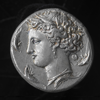

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, an exquisite coin from the late 5th century BCE, renowned for its intricate artistry and high relief, created by artists such as Kimon and Euinatos. The coin has captivated enthusiasts for centuries with its intriguing design and historical significance. Notably, it was a key element in the collection of Theodore Roosevelt, an American president known for his reformative policies. Roosevelt's frustration with the mundane design of contemporary American coins compelled him to advocate for more artistic currency, leading to his comparison of modern coins unfavorably to classical masterpieces like the dekadrachm. His initiative resulted in a partnership with sculptor 

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


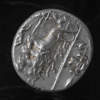

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the Syracuse dekadrachm, an exquisite coin from the late 5th century BCE, renowned for its stunning craftsmanship and high relief, which has captivated collectors for centuries. This particular piece, attributed to designers like Kimon and Euinatos, showcases the advanced techniques of ancient Greek coinage. Notably, it has been a subject of interest for Theodore Roosevelt, an American president known for his reformative policies. His frustration with the mundane design of contemporary American coins led him to compare them unfavorably with classical masterpieces like the dekadrachm. His initiative resulted in the creation of the 1907 twenty-dollar gold piece, often hail

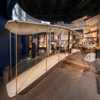

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wright Flyer, an iconic aircraft that symbolizes the dawn of the aerial age. Built by Wilbur and Orville Wright, the Flyer is powered by a 12-horsepower engine and utilizes a unique sprocket-and-chain system to drive its dual pusher propellers. Its historic first flight occurred on December 17, 1903, at Kitty Hawk, North Carolina, when Orville piloted the aircraft for 12 seconds, covering 36 meters (120 feet). The Wright brothers' groundbreaking work in aeronautical engineering, including the use of wind tunnels and the development of the wing warping technique for flight control, laid the foundation for modern aviation. After sustaining damage, the Flyer was restored and has been on d

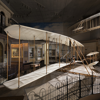

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit showcases the Wright Flyer, an iconic aircraft that symbolizes the dawn of the aerial age. Built by Wilbur and Orville Wright, the Flyer is powered by a 12-horsepower engine and features a unique sprocket-and-chain system driving two pusher propellers. Its historic first flight occurred on December 17, 1903, at Kitty Hawk, North Carolina, when Orville piloted the aircraft for 12 seconds, covering 36 meters (120 feet). The Wright brothers' groundbreaking work in aeronautical engineering, including the use of wind tunnels and the development of the wing warping technique for flight control, laid the foundation for modern aviation. After sustaining damage, the Flyer was restored an

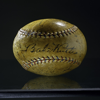

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an autographed baseball from the 1926 New York Yankees, signed by baseball icons Babe Ruth and Lou Gehrig. Gehrig, who played an unprecedented 2,130 consecutive games for the Yankees, became a symbol of resilience after being diagnosed with amyotrophic lateral sclerosis (ALS) in 1939, which is often referred to as Lou Gehrig's disease. The baseball, made from a cork center, wool layers, and a horsehide cover, measures 3 inches in diameter. While this item is currently not on display, it is part of the National Museum of American History's collection, generously gifted by the Elliot Spencer family through Brad Spencer, and serves as a poignant reminder of the extraordinary talent and resili

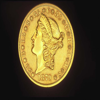

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a unique gold coin from the United States Mint, specifically minted in Philadelphia. The coin presents a Liberty head on its obverse, with the date inscribed below and the circumference detailing the weight and fineness of the coin. On the reverse side, an eagle is depicted, but notably, it bears the Latin motto DEO EST GLORIA instead of the usual IN GOD WE TRUST. This design was conceived to enhance the international marketability of American coins, akin to the four-dollar gold Stella coin. Among a total of nine known gold coins of this design, this particular piece was minted in 1879 and is currently not on display. It measures .2 cm by 3.4 cm and is part of the National Museum of Americ

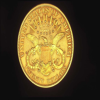

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a unique gold coin from the United States Mint, specifically minted in Philadelphia. The coin presents a Liberty head on its obverse, with the date inscribed below and the Latin motto DEO EST GLORIA inscribed around it. On the reverse side, an eagle is depicted, but it notably includes the Latin inscription "IN EST GLORIA" instead of the usual "IN GOD WE TRUST." This design was conceived to enhance the international marketability of American coins, akin to the four-dollar gold Stella coin. Among a total of nine known gold coins of this design, this one is currently not on display but holds a catalog number of 1994.0371. Measuring just .2 cm in height and 3.4 cm in diame

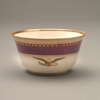

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Abraham Lincoln's coffee cup, a poignant artifact from a pivotal moment in American history. On April 14, 1865, just before heading to Ford's Theatre for the last time, President Lincoln inadvertently left this cup on a windowsill. A White House servant preserved the cup as a memento of that tragic night. In 1887, Capt. D.W. Taylor gifted the cup to Robert Todd Lincoln, the eldest son of Abraham Lincoln, who cherished it as a family heirloom. The cup is crafted from ceramic and features a striking purple color with white and gold trim, measuring about 3 1/4 inches in height. This artifact was donated to the Smithsonian Institution by Lincoln Isham, Lincoln's great-grandson, in 1958. It sta

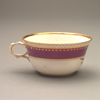

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit showcases a significant piece of American history: Abraham Lincoln's coffee cup, which dates back to 1887 and was gifted to the Smithsonian Institution by Lincoln Isham, the great-grandson of President Lincoln. The cup has a compelling story; on April 14, 1865, just before heading to Ford's Theatre for the last time, President Lincoln inadvertently left this cup on a windowsill, where it was preserved by a White House servant. Years later, Captain D.W. Taylor gifted the cup to Robert Todd Lincoln, the eldest son of Abraham Lincoln, who cherished it as a family heirloom. The cup is crafted from ceramic and features a striking purple color with white and gold trim, measuring about

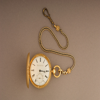

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary pocket watch once owned by Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this particular watch served as a notable symbol of his success in his legal career. The movement was crafted in Liverpool, a center for watch manufacturing, while the case was made by an unknown American maker. The watch is recognized for its exceptional movement, which can keep time with remarkable accuracy when properly maintained, and its 18K gold case is of the highest standard. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonathan Dillon during repairs on April 12, 1861, coincidin

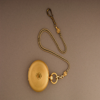

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit showcases a significant pocket watch once owned by Abraham Lincoln, purchased in the 1850s from jeweler George Chatterton in Springfield, Illinois. While Lincoln was not known for his vanity, this fine gold watch served as a notable symbol of his success in his legal career. The movement was crafted in Liverpool, a center for watch manufacturing, while the case was made by an unknown American maker. The watch is recognized for its exceptional movement, which can keep time with remarkable accuracy when properly maintained, and its 18K gold case is of the highest standard. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonathan Dillon during repair

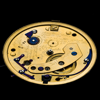

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary pocket watch once owned by Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this fine gold watch served as a notable symbol of his success in his legal career. The watch's movement, crafted in Liverpool—a center for watch manufacturing—boasts one of the finest grades available, capable of accurate timekeeping within seconds each day. The case, made in the United States, is 18K gold, showcasing exceptional quality. A fascinating aspect of this watch is the hidden engravings placed by two watchmakers during the tumultuous Civil War period. Jona

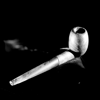

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Albert Einstein's pipe, dating back to around 1948, which serves as a remarkable artifact linked to one of the most influential scientists in history. Known for his groundbreaking theory of relativity and a Nobel Prize laureate, Einstein is also recognized for his distinctive appearance, often including a pipe. Although he reduced his smoking later in life due to health concerns, he continued to value the experience of holding a pipe. This particular pipe shows signs of wear, including a hole in its bit, and was gifted to his friend Gina Plunguian in 1948. The Smithsonian acquired this significant item in 1979. It is part of a larger collection of over 1,000 artifacts displayed at Smithson

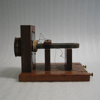

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the National Museum of American History focuses on the revolutionary invention of the telephone by Alexander Graham Bell, who received the first patent for his device on March 7, 1876. Just three days later, he successfully communicated with his assistant, Thomas Watson, marking a significant milestone in communication history. The exhibit includes one of the two telephones used in a landmark demonstration between Boston and Salem on November 26, 1876. This particular telephone is unique, featuring an iron diaphragm and two electromagnets, and does not possess the wooden casing typically found on other telephones in the Smithsonian's collection. Acquired from the American Telephone & Telegraph C

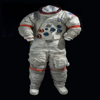

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the Apollo 17 spacesuit, an iconic relic from the final Apollo mission that landed humans on the moon in December 1972. The mission was launched on December 7, 1972, by a Saturn V rocket and included three astronauts: Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, the only geologist to have walked on the moon. While Evans remained in the command module, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region and conducted three moonwalks over three days, collecting 110 kilograms of lunar samples and driving a lunar rover for 35 kilometers. Their mission concluded with a Pacific Ocean landing on December 19, 1972

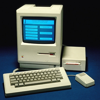

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apple "Classic" Macintosh Personal Computer, which was launched in January 1984. Apple Inc. introduced a revolutionary concept with its Macintosh Personal Computer, allowing users to interact with the device through visual icons rather than traditional command lines. This innovation was inspired by work at Xerox's Palo Alto Research Center, which Apple capitalized on, famously unveiling the Macintosh during Super Bowl XVIII for about $2,500. The computer initially came with 128K of RAM, but the release of the Macintosh 512 KB, known as "Fat Mac," in September 1984, provided users with enhanced capabilities thanks to its 8 MHz Motorola 68000 microprocessor and 512 KB of RAM. It also inc

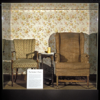

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an upholstered wing chair that was famously used by Archie Bunker, a character portrayed by Carroll O'Connor in the groundbreaking sitcom "All in the Family." The chair, upholstered in a vibrant orange-yellow woven fabric and supported by a durable wooden frame, likely dates back to the 1940s, although its exact origins are not documented. It was originally purchased from a thrift store in Southern California and was utilized throughout the show's run from 1971 to 1979, until a reproduction was created for the final season after the original was donated to the Smithsonian. "All in the Family," created by Norman Lear and Bud Yorkin, was a revolutionary sitcom that addressed pressing social 

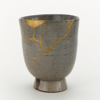

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable tea bowl from the 17th century, specifically from the White Satsuma style, originating from Kagoshima prefecture in Japan. The bowl, crafted from stoneware and finished with a clear crackled glaze, has a unique history marked by a breakage that led to its restoration through the Japanese technique of kintsugi, or golden joinery. Unlike typical restoration methods that aim to hide damage, kintsugi embraces the bowl's imperfections, accentuating its past. The repairs involve lacquer, a natural resin derived from tree sap that, once cured, exhibits remarkable strength and water resistance. The practice of applying gold to these repairs became more widespread in Japan during the l

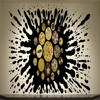

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the work of Yinka Shonibare, an influential artist born in London in 1962. It includes a striking collection of 25 circular canvases, each varying in size, arranged over a large-scale ink splatter pattern that has been meticulously created with a template. The canvases are adorned with foliate patterns, painted in black and gold, using Dutch wax printed fabrics. Shonibare's artistic journey is evident through his transition from grid-like square canvases to these dynamic forms, which challenge conventional notions of edges. The term "black gold" alludes to Africa's valuable oil resources and serves as a backdrop for the splatter technique, which playfully engages with the work of Jackson P

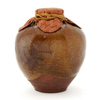

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibition "Chigusa and the Art of Tea," housed at the Arthur M. Sackler Gallery, explores the intricate relationship between Japanese tea culture and the art of collecting. At its heart is the tea-leaf storage jar known as Chigusa, which was transformed from a simple Chinese jar into a revered object through the practices of naming and displaying associated with chanoyu, the formal tea ceremony. 16th-century tea diaries provide invaluable context, revealing the admiration that tea practitioners had for Chigusa, particularly noting how it was presented in ornamental silks, including a distinctive mouth cover and net bag. Additional adornments, such as silk cords, were later added to honor the jar's esteemed

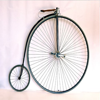

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The National Museum of American History presents a striking reflection on the arrival of spring with an original 1886 Columbia Light Roadster high-wheel bicycle. This historical piece, which was sold for about $135, was crafted by the Pope Manufacturing Co., the first bicycle manufacturer in the United States. It features a 53-inch front wheel with 60 spokes and an 18-inch rear wheel with 20 spokes, showcasing the variety of sizes available to cyclists at the time. The exhibit also includes a vintage photograph from 1879, which captures one of the first organized biking tours in America, featuring Charles E. Pratt, the first president of the League of American Wheelmen, as he leads fellow cyclists outside Readv

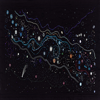

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit “Milky Way, Starry Night #2” by Margaret Nazon, a Gwich'in artist from Tsiigehtchic, showcases her artistic interpretation of the cosmos. Created in 2021, this piece emerged from Nazon's childhood fascination with the night sky, which she revisited in her later years after encountering Hubble Space Telescope images. The artwork features swirling galaxies, representing a significant evolution in Gwich'in beadwork traditions. It is part of the “Lights Out: Recovering Our Night Sky” exhibition at the Smithsonian's National Museum of Natural History, which highlights the detrimental effects of light pollution on the night sky and its broader implications for ecosystems and human cultures. The exhibition

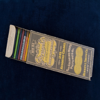

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a historic pack of Crayola Crayons from 1903, housed at the Smithsonian's National Museum of American History. Invented by Edwin Binney and C. Harold Smith, the crayons were crafted from paraffin wax and non-toxic pigments, making them safe and accessible for children. The name "Crayola," coined by Alice Binney, combines the French word for chalk, "craie," with "oleaginous," indicating their waxy texture. This particular set, aimed at young artists, is one of the earliest produced and includes 28 colors, such as celestial blue and rose pink. The box, labeled "No. 51, Young Artists Drawing Crayons," contains 22 original crayons and features a charming illustration of a girl coloring. As a s

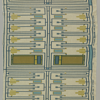

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a striking textile designed by the renowned American architect Frank Lloyd Wright, who lived from 1867 to 1959. The piece was produced by F. Schumacher & Co., a New York-based manufacturer established in 1889. It presents a geometric pattern characterized by rectangular blocks in light blue and olive tones, all intricately outlined with fine lines of darker blue on an off-white background. The textile measures 120 cm by 57.5 cm (47 1/4 in. by 22 5/8 in.) and employs the screen printing technique. Attached to its upper back are samples of five alternative colorways, showcasing the versatility of the design. This textile was gifted to the museum by Mr. and Mrs. Burton Tremaine in 1956 and is

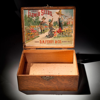

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an antique seed box from the 1890s, specifically from D.M. Ferry & Co., as part of the Smithsonian's celebration of National Garden Month. In the 19th century, seed packets were typically stored in decorative wooden boxes adorned with colorful labels, serving as effective marketing tools on store counters. This particular seed box is significant for its association with the invention of the “commission box,” a display method that enhanced retail marketing strategies. Acquired by the Smithsonian in 1986, it serves as a testament to the advertising practices of the time. Seed companies also distributed seasonal catalogs to amateur gardeners, preparing them for the gardening season. The Smith

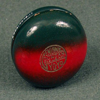

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the Smithsonian's National Museum of American History highlights the intriguing history of the yo-yo, a toy that became a staple of American childhood thanks to the entrepreneurial spirit of Donald F. Duncan Sr. The story begins in 1928 when Duncan discovered the yo-yo during a business trip to San Francisco, where it was being sold by Pedro Flores, a Filipino immigrant who had begun marketing the toy under the name “yo-yo,” which translates to “come-come” in his native language. By early 1929, Flores had founded his own company and produced over 100,000 wooden yo-yos, understanding the need for live demonstrations to sell his product. Duncan, recognizing the toy's potential, invested $5,000 to 

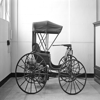

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the Duryea Automobile, an iconic piece of American automotive history dating back to 1893-94. This vehicle is one of the earliest automobiles manufactured in the United States, having been road-tested by Frank Duryea on September 21, 1893, in Springfield, Massachusetts. The Duryea Motor Wagon Company, founded by Frank, his brother Charles, and their investors in 1896, was the first company to produce and sell automobiles in America. The automobile is powered by a one-cylinder, four-cycle, four-horsepower water-cooled gasoline engine, which is positioned almost horizontally under the body. It features a gear transmission, a spray carburetor, and a make-and-break ignition. The Duryea was dona

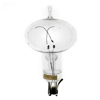

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Edison Light Bulb, an invention that revolutionized lighting, created in 1879 by the esteemed inventor Thomas Edison. This carbon-filament bulb was integral to Edison's first public demonstration of the electric incandescent lamp, which was the first practical version of its kind. The bulb functions by conducting an electrical current through a metal filament, heating it to a glowing state. To protect the filament from air, it is enclosed in a glass bulb filled with inert gas. This landmark demonstration occurred at Edison's Menlo Park laboratory on New Year's Eve, 1879. Edison's contributions to technological innovation are extensive, with a record of 1,093 patents to his credit. His 

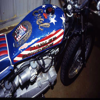

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Evel Knievel's iconic 1972 Harley-Davidson XR-750, a motorcycle that symbolizes the daring spirit of one of America's most famous daredevils. Evel Knievel, born Robert Craig Knievel, became a national sensation in the 1960s, captivating audiences with his thrilling stunts, many of which were performed on this very motorcycle. Over his career, Knievel suffered numerous injuries, breaking 35 to 40 bones, a testament to the high risks he took while performing. The XR-750, weighing about 300 pounds and made from steel, aluminum, and fiberglass, was chosen for its light weight and reliability. This particular motorcycle was used in some of Knievel's most spectacular jumps, including a notable l

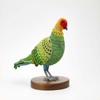

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features Laurel Roth Hope's intriguing work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This piece employs humor to confront the grave issue of species extinction, using crocheted suits that enable common rock pigeons to impersonate extinct North American birds. While it doesn't restore biodiversity, it certainly plays with the notion in a visually captivating way. Hope's artistic process involves traditional techniques such as carving, embroidery, crochet, and collage, transforming simple materials into intricate animal sculptures that are both whimsical and thought-provoking. Her background as a park ranger shapes

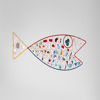

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features "Fish," a striking sculpture by Alexander Calder, created in 1945 and housed at the Hirshhorn Museum and Sculpture Garden in Washington, D.C. Calder, who hailed from a lineage of artists, initially pursued a degree in mechanical engineering before fully committing to his artistic career. After working as a freelance illustrator, he moved to Paris, where he was influenced by avant-garde artists and began creating wire sculptures, which critics referred to as “drawings in space.” In 1931, inspired by the simplicity of Piet Mondrian's studio, he invented the “mobile,” a kinetic sculpture that moves with air currents. He also created “stabiles,” which are static sculptures, and standing mobiles

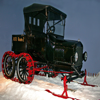

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a 1921 Ford Model T equipped with a unique snow attachment, highlighting the ingenuity of rural mail carriers in the early 1900s. As these carriers began utilizing automobiles, they soon realized that navigating snowy terrains posed significant challenges. In 1906, innovator Virgil White addressed this issue by transforming traditional vehicles into snowmobiles by retrofitting them with skis and caterpillar treads. His first prototype was a Buick Model G, but as the Ford Model T became more popular, he began offering kits specifically for it. By 1922, these kits were being sold for $250 to $400 from White's company in New Hampshire. After selling the patents to Farm Specialty Manufacturing

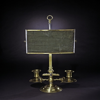

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact from American history, specifically a brass candle stand associated with George Washington. After two successful terms as President, Washington chose to retire rather than run for a third, delivering his Farewell Address in September 1796. Published in The American Daily Advertiser, his message underscored the importance of national unity over regional or party differences, positioning it as crucial for the preservation of liberty. The candle stand, with its adjustable candlesticks and a reflector lined in green silk to amplify candlelight, is believed to have been used by Washington while composing his address. This piece, along with other family heirlooms, was sold

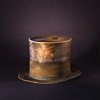

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features President Abraham Lincoln's top hat, an important artifact displayed at the Smithsonian's National Museum of American History. Measuring 6'4”, Lincoln was an imposing figure, and his choice of high top hats further elevated his stature. This particular hat was crafted by J.Y. Davis, a hat maker from Washington, and features a black silk mourning band that commemorates his son Willie, who died in 1862. While the specific date of acquisition is unknown, it is noted that Lincoln last wore this hat on April 14, 1865, the evening he attended Ford's Theatre. After his assassination, the War Department preserved the hat along with other items left behind. In 1867, it was transferred to the Smiths

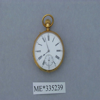

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary pocket watch that once belonged to the renowned Helen Keller, born on June 27, 1880. Keller's life story is a remarkable narrative of resilience; after becoming deaf and blind at a young age, she overcame significant barriers with the help of her teacher, Anne Sullivan. Keller learned to communicate, read, write, and ultimately graduated from Radcliffe College in 1904 as the first deaf-blind person to earn a Bachelor of Arts degree. The watch, gifted to her by John Hitz in 1892, is a Swiss-made device that allows time to be discerned through touch, featuring pins around its edge to indicate the hours. This watch was not only a personal treasure for Keller, but it also symb

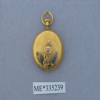

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit showcases a remarkable gold pocket watch that once belonged to Abraham Lincoln, purchased in the 1850s from jeweler George Chatterton in Springfield, Illinois. While Lincoln was not known for his vanity, this fine timepiece stands as a testament to his success as a practicing lawyer. The watch's movement, crafted in Liverpool—a center for watch manufacturing—boasts one of the finest grades available, capable of accurate timekeeping within seconds each day. The case, made in the United States, is 18K gold, showcasing exceptional quality. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonathan Dillon during repairs on April 12, 1861, coinciding wit

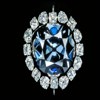

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond, a primary gem that captivates with its dark gray-blue coloration. Weighing an impressive 45.52 carats, the diamond is cut into a modified antique cushion shape, enhancing its allure and elegance. This exquisite piece was sourced from India, showcasing not only the beauty of the gem itself but also the rich heritage of jewelry making. It is part of the Mineral Sciences collection, specifically within the Gems category, and is recorded with the USNM Number NMNH G3551-00. The record was last updated on September 26, 2022, and it contains the following information:
==> Ground truth answer: This exhibit features a stunning diamond necklace crafted by Cartier, Inc., showcasin

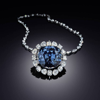

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond, a primary gem that captivates with its dark gray-blue coloration. Weighing an impressive 45.52 carats, the diamond is cut into a modified antique cushion shape, which enhances its allure and elegance. This exquisite piece was sourced from India, showcasing not only the beauty of the gem itself but also the rich heritage of jewelry making. It is part of the Mineral Sciences collection, specifically within the Gems category, and is recorded with the USNM Number NMNH G3551-00. The necklace, crafted by the esteemed Cartier, Inc., showcases the artistry of the time. This particular gem and its accompanying necklace were last worn by the illustrious Helen 

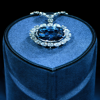

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., showcasing a single primary gem weighing an impressive 45.52 carats. The gemstone is cut into a modified antique cushion shape, enhancing its allure and elegance. This piece is sourced from India, further emphasizing its luxurious origins. It is part of the Mineral Sciences collection, specifically within the Gems category, and is recorded under the USNM Number NMNH G3551-00. The necklace's unique characteristics and its representation of high-quality craftsmanship make it a significant highlight for enthusiasts of fine jewelry and mineral sciences alike.
==> Ground truth answer: On display 

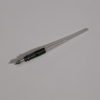

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an Esterbrook pen that holds significant historical importance as it was used by President Lyndon B. Johnson to sign the Civil Rights Act of 1964 on July 2, 1964. Part of the Smithsonian's National Museum of African American History and Culture collection, this pen is one of over 70 identical pens that Johnson distributed to key figures in the Civil Rights Movement. The passage of this crucial legislation was a challenging journey, initially introduced by President John F. Kennedy before his assassination in November 1963. President Johnson's leadership was instrumental in overcoming significant resistance, including a 57-day filibuster in the Senate, making it the longest in Congressional

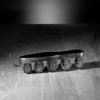

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Volito, an inline skate dating back to 1823, crafted by Robert John Tyers. As the Winter Olympics highlight various ice sports, it's intriguing to consider how skaters of the past prepared for their sport without access to indoor rinks. The Volito stands out due to its unique design, which includes a wooden sole and a single row of five wooden wheels, along with a curved iron bar that functions as a basic brake. Its innovative wheel size—larger in the center and smaller at the ends—allowed for improved maneuverability during turns, making it a significant advancement in the history of sports. Although this remarkable artifact is part of the National Museum of American History's collect

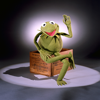

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Kermit the Frog, a character created by Jim Henson, who has been a staple of children's television since his debut in 1955 on "Sam and Friends." Kermit, known for his calm and rational nature, navigates through the delightful chaos that surrounds him, particularly on The Muppet Show. His signature song, “Bein' Green,” poignantly discusses the challenges he faces due to his color, ultimately leading to a message of self-acceptance. The puppet on display, made from a combination of materials including synthetic fiber and felt, stands at 27 inches tall and is part of the "Entertainment Nation" exhibition at the National Museum of American History.
==> Ground truth answer: This exhibit showcas

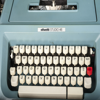

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the typewriter of the illustrious science fiction author Octavia Estelle Butler (1947–2006). Butler is celebrated for her groundbreaking works, including the five-volume Patternist series, the Xenogenesis trilogy—also known as Lilith's Brood—and the influential novels Parable of the Sower and its sequel, Parable of the Talents, along with the short story collection Bloodchild and Other Stories. Her writing often merges African American history with speculative fiction, exploring themes of alien life and human psychology, a style that has become synonymous with Afrofuturism. By centering characters from the African diaspora in her early novels, such as Wild Seed and Kind

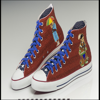

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features "Kiowa Ah-Day," a striking pair of sneakers created by Kiowa artist Teri Greeves in 2004. This artwork, made from cotton canvas and adorned with intricate beadwork, represents the Kiowa culture and is part of the National Museum of the American Indian collection. Measuring 33 x 11 x 15 cm, the piece was purchased by the museum from Thirteen Moons Gallery in Santa Fe, New Mexico. It highlights the ongoing relevance of traditional Native American art forms in modern contexts and the importance of understanding cultural heritage. The catalog number for this artwork is 26/3325, which visitors can use for further inquiries regarding its history and significance.
==> Ground truth answer: This exh

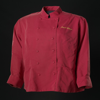

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant collection from the Smithsonian's National Museum of African American History and Culture, generously gifted by Dooky Chase's Restaurant and Chef Leah Chase. Known as “The Queen of Creole Cuisine,” Chase played a crucial role in showcasing New Orleans Creole cooking worldwide. She famously stated that “we changed the world over a bowl of gumbo,” underscoring the restaurant's importance as a venue for civil rights strategy meetings. Alongside her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop into a fine-dining experience, complete with elegant white tablecloths and works by African American artists. The exhibit features Chase's distincti

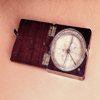

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket compass that dates back to approximately 1804, originally purchased by Meriwether Lewis for the Lewis and Clark Expedition. Made by Thomas Whitney in Philadelphia, this silver-plated brass compass was housed in a mahogany case and was equipped with a graduated rim, a paper dial, and two small brass sight vanes, all enclosed in a leather carrying case. The purpose of this compass—whether it was intended for Lewis himself or as a gift for his fellow explorer William Clark—remains a mystery. The Corps of Discovery, led by Lewis and Clark, embarked on their journey in May 1804 to explore new territories and establish diplomatic relations with Native American tribes. Althoug

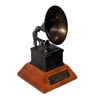

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the esteemed 1960 Grammy Award belonging to comedian Bob Newhart, celebrating his significant impact on the comedy genre. Born on September 5, 1929, in Oak Park, Illinois, Newhart has enjoyed a successful career for over sixty years, known for his deadpan delivery and insightful commentary on societal issues. His groundbreaking comedy album, The Button-Down Mind of Bob Newhart, was the first comedy LP to reach No. 1 on the Billboard charts and earned him a Grammy for Album of the Year, marking him as the only comedian to win the Best New Artist Grammy. Newhart's television career includes starring roles in iconic sitcoms like The Bob Newhart Show and Newhart, both of which have left a last

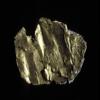

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant gold nugget from 1848, housed at the Smithsonian's National Museum of American History. This nugget is believed to be the first piece of gold discovered at Sutter's Mill in California, an event that catalyzed the gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall discovered a shiny object in the mill's tailrace. Upon inspection, he identified it as a thin scale of pure gold, which he confirmed by biting it. Later that year, Sutter presented the nugget to Capt. Joseph L. Folsom, who documented it as Specimen No. 1, marking it as the first gold found in Northern California. By August 1848, this nugget and other samples were sent to Wa

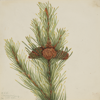

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the watercolor painting "Lodgepole Pine (Pinus Contorta murrayana)" by Mary Vaux Walcott, created in 1921 and measuring 10 x 7 inches. This piece is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's foray into botanical illustration was inspired by a summer request from a botanist to paint a rare arnica flower. After marrying Charles Doolittle Walcott in 1914, they spent summers in the Canadian Rockies, where she produced numerous watercolor studies of local flora. Between 1925 and 1929, a selection of her illustrations was published in the five-volume "North American Wild Flowers," and she later illustrated "North American Pitcher Plants" in

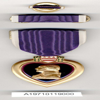

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the esteemed United States Purple Heart, a medal that is heart-shaped and made from a combination of copper alloy, gold plating, and enamel. The medal is set against a striking purple enamel background and prominently displays a profile relief bust of George Washington. Above the bust is a shield that showcases Washington's family coat of arms. The reverse side of the medal is inscribed with "FOR MILITARY MERIT," honoring those who have displayed exceptional bravery. It is attached to a silk ribbon that is purple with a white edge stripe, enhancing its visual appeal. The medal is made from a mix of materials, including copper alloy, gold plating, and enamel, and has dimensions of 3.7 cm by

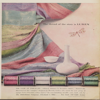

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit "The Thread of the Story Is Lurex: The Look of Porcelain," created around 1953, highlights the work of Dorothy Liebes (1897–1972), an influential American textile designer. Liebes left a significant imprint on various design areas, including interiors, fashion, and film throughout the 1930s to the 1960s, where she is often referred to as the “American Modernist.” Her unique style, known as the “Liebes Look,” is characterized by vibrant colors, rich textures, and metallic accents, blending to create a distinctive aesthetic that defined the American modernist movement. Over the years, Liebes collaborated with notable figures such as Frank Lloyd Wright and fashion designers like Adrian, producing iconi

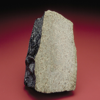

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the Nakhla Meteorite Fragment at the Smithsonian's National Museum of Natural History, a remarkable specimen among the thirty-four known Martian meteorites. This meteorite fell on June 28, 1911, in the Nakhla region of Alexandria, Egypt, where it was observed exploding in the atmosphere before breaking into about 40 pieces, collectively weighing 22 pounds. Many of these fragments were found buried up to a meter deep in the ground. The Smithsonian acquired two samples shortly after the fall, and in 1962, it added a significant 480-gram fragment, resulting in a total of 650 grams of Nakhla fragments by the 1970s. The Nakhlites, as these Martian meteorites are called, consist predominantly of 

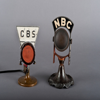

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an RCA Type 50-A microphone, a significant artifact from President Franklin D. Roosevelt's "Fireside Chats," which began on March 12, 1933. These informal radio broadcasts provided a vital means for Roosevelt to connect with the American people during the Great Depression, a time marked by economic turmoil and widespread unemployment. His ability to speak directly to listeners through the radio allowed him to reassure and inspire a nation in crisis. The first chat took place in the Lincoln Study, with subsequent broadcasts occurring in the Diplomatic Reception Room of the White House. The microphone on display, which was used during these historic broadcasts, is a notable piece from the Na

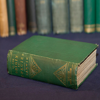

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the groundbreaking book "On the Origin of Species" by Charles Darwin, published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the May 11, 1820, launch of the HMS Beagle from Woolwich Dockyard in London, which was essential for Darwin's research. The Beagle was launched from the Thames and underwent several modifications before embarking on its second survey voyage on December 27, 1831, where Darwin served as a young naturalist. Over five years, he meticulously gathered fossils, examined plant specimens, and studied geological formations in South America and the Galápagos Islands, which informed his revolutionary theory of evolution by natural sel

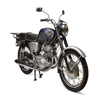

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Robert M. Pirsig's 1966 Honda Super Hawk motorcycle, a significant artifact tied to his influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Released in 1974, the book quickly became a bestseller, selling a million copies in its first year alone and igniting a cultural movement that encouraged individuals to rethink their interactions with technology and strive for a more balanced life. The narrative was inspired by Pirsig's 1968 road trip with his son Chris, covering 5,700 miles from Minnesota to San Francisco. This journey not only strengthened their father-son relationship but also provided Pirsig with deep insights into self-awareness and human experie

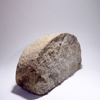

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the Plymouth Rock Piece from 1620, an iconic artifact located at the National Museum of American History. This rock is traditionally recognized as the landing site of the Mayflower Pilgrims, led by William Bradford, who settled in Plymouth, Massachusetts, in 1620. Bradford was a key figure in the early settlement and served as governor for three decades, playing a crucial role in what would become the American Thanksgiving tradition. The rock's history includes a notable event in 1774 when it was moved from its original shoreline location to the town square, where it unfortunately split into two halves. The lower half remained in its original spot, while the upper half was taken to a meetin

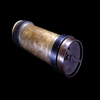

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Pneumatic Mail Container from 1953, housed at the Smithsonian's National Postal Museum. In the late 1800s, cities began implementing pneumatic tube systems beneath their streets to facilitate mail transport. These canisters, known as carriers, were capable of holding up to 500 letters and were propelled through the tubes by compressed air, reaching speeds of about 35 miles per hour while spinning. At its highest efficiency, the pneumatic system moved an impressive six million pieces of mail each day, with a dispatch rate of five carriers per minute. The first pneumatic tube service began in Philadelphia in 1893, followed by a launch in New York City in 1897, and eventually expanded to 

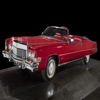

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The "Rock 'n' Roll Ride" exhibit at the Smithsonian's National Museum of African American History and Culture features an iconic 1973 red convertible Eldorado Cadillac that belonged to the legendary rock musician Chuck Berry. This vehicle is prominently displayed in the museum's “Musical Crossroads” section, where it serves as a tribute to Berry's significant impact on rock music and African American culture. The Cadillac was part of Berry's personal collection and was prominently featured in the 1987 documentary Hail! Hail! Rock 'n' Roll, which celebrated Berry's 60th birthday through two concerts. A memorable moment in the film occurs when Berry drives this Cadillac onto the stage of the Fox Theater in St. Lo

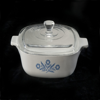

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a classic white casserole dish from CorningWare, dating back to 1965, adorned with the brand's signature blue cornflower design. This dish is a testament to the evolution of kitchenware, as it was originally created from Pyroceram, a glass-ceramic material that was developed for military applications during World War II. Its unique properties allowed it to withstand rapid temperature shifts while resisting stains and odors, making it a versatile choice for cooking, freezing, and serving. In the 1990s, CorningWare shifted towards ceramic stoneware to meet consumer demand for a greater variety of colors and styles, yet the original glass-ceramic line was reintroduced in 2

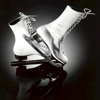

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the autographed ice skates of Sonja Henie, a legendary Norwegian figure skater from the early to mid-1940s. Henie was a trailblazer in the sport, introducing white leather skates to women's figure skating during the late 1920s and 1930s, a significant departure from the traditional black skates. She won her first world title in 1927 and went on to dominate the sport, winning ten consecutive titles. Henie was not only a remarkable skater but also a pioneer in choreography, incorporating dance into her performances and routines. Her Olympic accolades include gold medals in ladies' singles at the Winter Olympics in 1928, 1932, and 1936. After her success in figure skating, she transitioned to

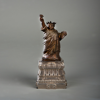

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features one of the first models of the Statue of Liberty, commonly known as the American Committee Model. Produced in the United States, this statuette was created in large quantities, with the aim of funding the construction of the statue's pedestal in New York Harbor. The model is based on the design by French sculptor Frédéric-Auguste Bartholdi and was available in both six-inch and twelve-inch sizes. A national campaign promoted these statuettes, selling the six-inch version for one dollar and the twelve-inch version for five dollars. Richard Butler, a New York rubber manufacturer, led the American Committee that oversaw the production of these models. The campaign not only popularized the ima

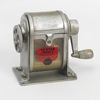

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Dexter Model 3 Pencil Sharpener, dating back to around 1920, produced by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. Constructed from metal, cellulose, and painted wood, this sharpener measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). As the back-to-school season approaches, this artifact may evoke fond memories of classroom experiences. The Dexter Model 3 represents a significant advancement in pencil sharpener technology, featuring a rotating wheel with calibrated openings for various pencil sizes, which improved upon the original model introduced in 1914 that only accommodated one size. By the 1920s, APSCO had expanded its product line to include

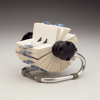

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit showcases the Rolodex Open Rotary Card File, a quintessential office supply that has influenced business networking since its inception. Created by the Rolodex Corporation in the USA, this rotating card organizer is made from a combination of bent tubular metal, molded plastic, rubber, and paper, with dimensions of 18 x 18 x 16.5 cm (7 1/16 x 7 1/16 x 6 1/2 in.). The design allows for easy rotation and access to A-Z index cards, a method that was widely used for organizing business contacts before the digital era. Remarkably, the Rolodex continues to be utilized in contemporary workplaces, demonstrating its enduring appeal. Invented by Arnold Neustadter, a notable figure in offi

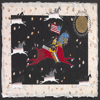

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the "Lakota Horse Mask," a striking work by Jim Yellowhawk, created in 2008 and representing the Cheyenne River Lakota tribe. This piece, crafted with acrylic on paper and embellished with gold leaf, highlights the deep connection between American Indians and horses, often referred to as the Horse Nation. Horses were integral to the lives of many tribes, serving as both companions in peaceful times and formidable allies in warfare. Historically, horses first appeared in the Americas over 40 million years ago but became extinct until their reintroduction by Columbus in 1493. The mask is part of the Smithsonian's National Museum of the American Indian collection and can be explored through th

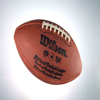

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wilson Duke football, a significant artifact in the history of American football, which has been the official ball of the Super Bowl since Super Bowl II in 1968. The football on display was used during Super Bowl XIV on January 20, 1980, at the Rose Bowl in Pasadena, California, where the Pittsburgh Steelers faced the Los Angeles Rams. The Steelers emerged victorious with a score of 31-19, marking their fourth Super Bowl win and allowing Terry Bradshaw to secure the Most Valuable Player title for the second year running. The Wilson Duke football is known for its high-quality leather and durability, having been introduced by Wilson Sporting Goods Co. in the early 1940s. While this parti

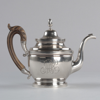

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an exquisite silver teapot crafted by Peter Bentzon, an American silversmith active from around 1783 to after 1850. The teapot showcases an elegant oval vase form supported by a spreading pedestal foot, with a gracefully curved spout capped with an incised patera and a scroll handle capped with a wooden leaf. Its hinged domed cover is finished with an acorn finial. The teapot is engraved with the scripted monogram "MC" and bears the name "Rebecca Dawson" along its base, indicating its historical significance. Created between 1817 and 1829, it is part of the collection at the Smithsonian National Museum of African American History and Culture, focusing on themes of slavery and freedom, craf

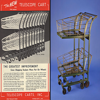

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The National Museum of American History presents the Telescoping Shopping Cart, an invention that emerged around 1949, created by Orla E. Watson from Kansas City, Missouri. This cart, which debuted in 1947 at Floyd's Super Market, features a design that allows multiple carts to nest together, thereby optimizing storage space—each cart requiring only one-fifth of the area of a conventional cart when parked. The exhibit forms part of the museum's first major showcase on food history, highlighting the significant shifts in eating and food consumption patterns in postwar America. For further insights into the changes in food shopping and other culinary innovations, visitors can explore the “FOOD: Transforming the A

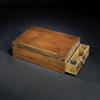

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Thomas Jefferson's portable writing desk, an essential tool used during the drafting of the Declaration of Independence in 1776. Designed by Jefferson himself, it includes a hinged writing board and a secure drawer for storing writing essentials. As a key figure in the Second Continental Congress, Jefferson sought to encapsulate the essence of American aspirations in the declaration, which was adopted on July 4, 1776. This document not only declared independence from Britain but also set forth principles that would guide the nation. The desk remained a lifelong companion to Jefferson, witnessing his journey as a patriot, diplomat, and president. In 1825, he gifted this desk to his granddau

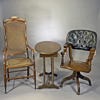

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an important historical artifact: the chair used by General Ulysses S. Grant during the surrender negotiations with General Robert E. Lee on April 9, 1865, at Appomattox Court House, Virginia. This meeting was crucial in determining the fate of Lee's troops and effectively marked the end of the Civil War. The chair, made of wood and measuring 37 1/2 inches in height, is a symbol of this significant moment. After the surrender, Union officers took pieces of the furniture as keepsakes, including Grant's chair and the table, which were later donated to the Smithsonian Institution and reunited by 1915. This exhibit is part of the "Price of Freedom" exhibition at the National Museum of American

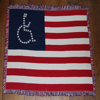

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a hand-altered lap blanket that incorporates the universal access symbol, a tribute to the advocacy efforts of the American Disabled for Attendant Programs Today (ADAPT). The blanket, made from cotton and measuring 129 cm by 95 cm, symbolizes the fight for civil rights among disabled individuals. ADAPT, founded in 1983, arose from the post-World War II disability rights movement, which saw individuals with disabilities unite to share their stories and push for political change. The blanket's design, adorned with stitched stars, emphasizes that civil rights are an essential entitlement for all. While it is currently not on display, this significant piece was donated by Carol Jones.
==> Grou

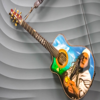

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the guitar of Carlos Vives, a Grammy Award-winning Colombian singer renowned for his vallenato music. Vallenato, a lively genre from Colombia's Atlantic coast, blends European instruments like the accordion with poetic lyrics and the rhythmic traditions of the Arhuaco indigenous people. Historically, this music was performed mainly by rural workers and cowboys, but in the 1990s, Vives and other artists innovatively incorporated pop and rock influences, allowing the genre to resonate with audiences beyond Colombia, including in the United States. The guitar on display, handmade by a Colombian luthier, features an airbrushed portrait of an Arhuaco and was last played by Vives at the Hollywoo

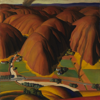

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a striking painting by Ross Dickinson, an artist whose work emerged from the Public Works of Art Project during the Great Depression. The painting depicts California's Central Valley, characterized by lush fields and a flowing river, symbolizing hope for families fleeing the Dust Bowl. However, Dickinson cleverly incorporates elements of danger—like a small controlled fire and a larger smoke plume in the background—highlighting the risks that exist even in paradise. This painting not only reflects the aspirations of families seeking a better life but also serves as a stark reminder of the precariousness of their situation, illustrating the challenges they faced and the realities they had t

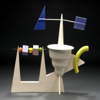

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the work of Peter Shire, an artist known for his vibrant ceramics, particularly his Weathervane Teapot from 1981. Born in Los Angeles in 1947, Shire creates delightful pieces using colorful slabs of clay, which are transformed into whimsical shapes that challenge conventional notions of functionality. The Weathervane Teapot is a playful amalgamation of geometric forms, including squares and balls, along with squiggly rods and open tubes. Shire's goal was to disrupt established, class-based perceptions of tea-drinking rituals, making them more accessible and engaging for everyone. While the teapot is visually intriguing and encourages tactile exploration, it also invites viewers to consider

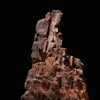

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the Spotsylvania tree stump, an evocative piece from the years 1864–65, located at the Smithsonian's National Museum of American History. This stump was once part of a large oak tree situated in a quiet meadow near Spotsylvania Court House, Virginia, until the morning of May 12, 1864. On that day, the area was engulfed in battle as Confederate forces under Gen. Robert E. Lee clashed with Union troops, leading to the meadow being dubbed the Bloody Angle. The oak tree was severely damaged during the conflict, with several Minié balls still embedded in its wood, serving as a stark reminder of the violence inflicted during the battle. The Battle of Spotsylvania Court House, which lasted from Ma

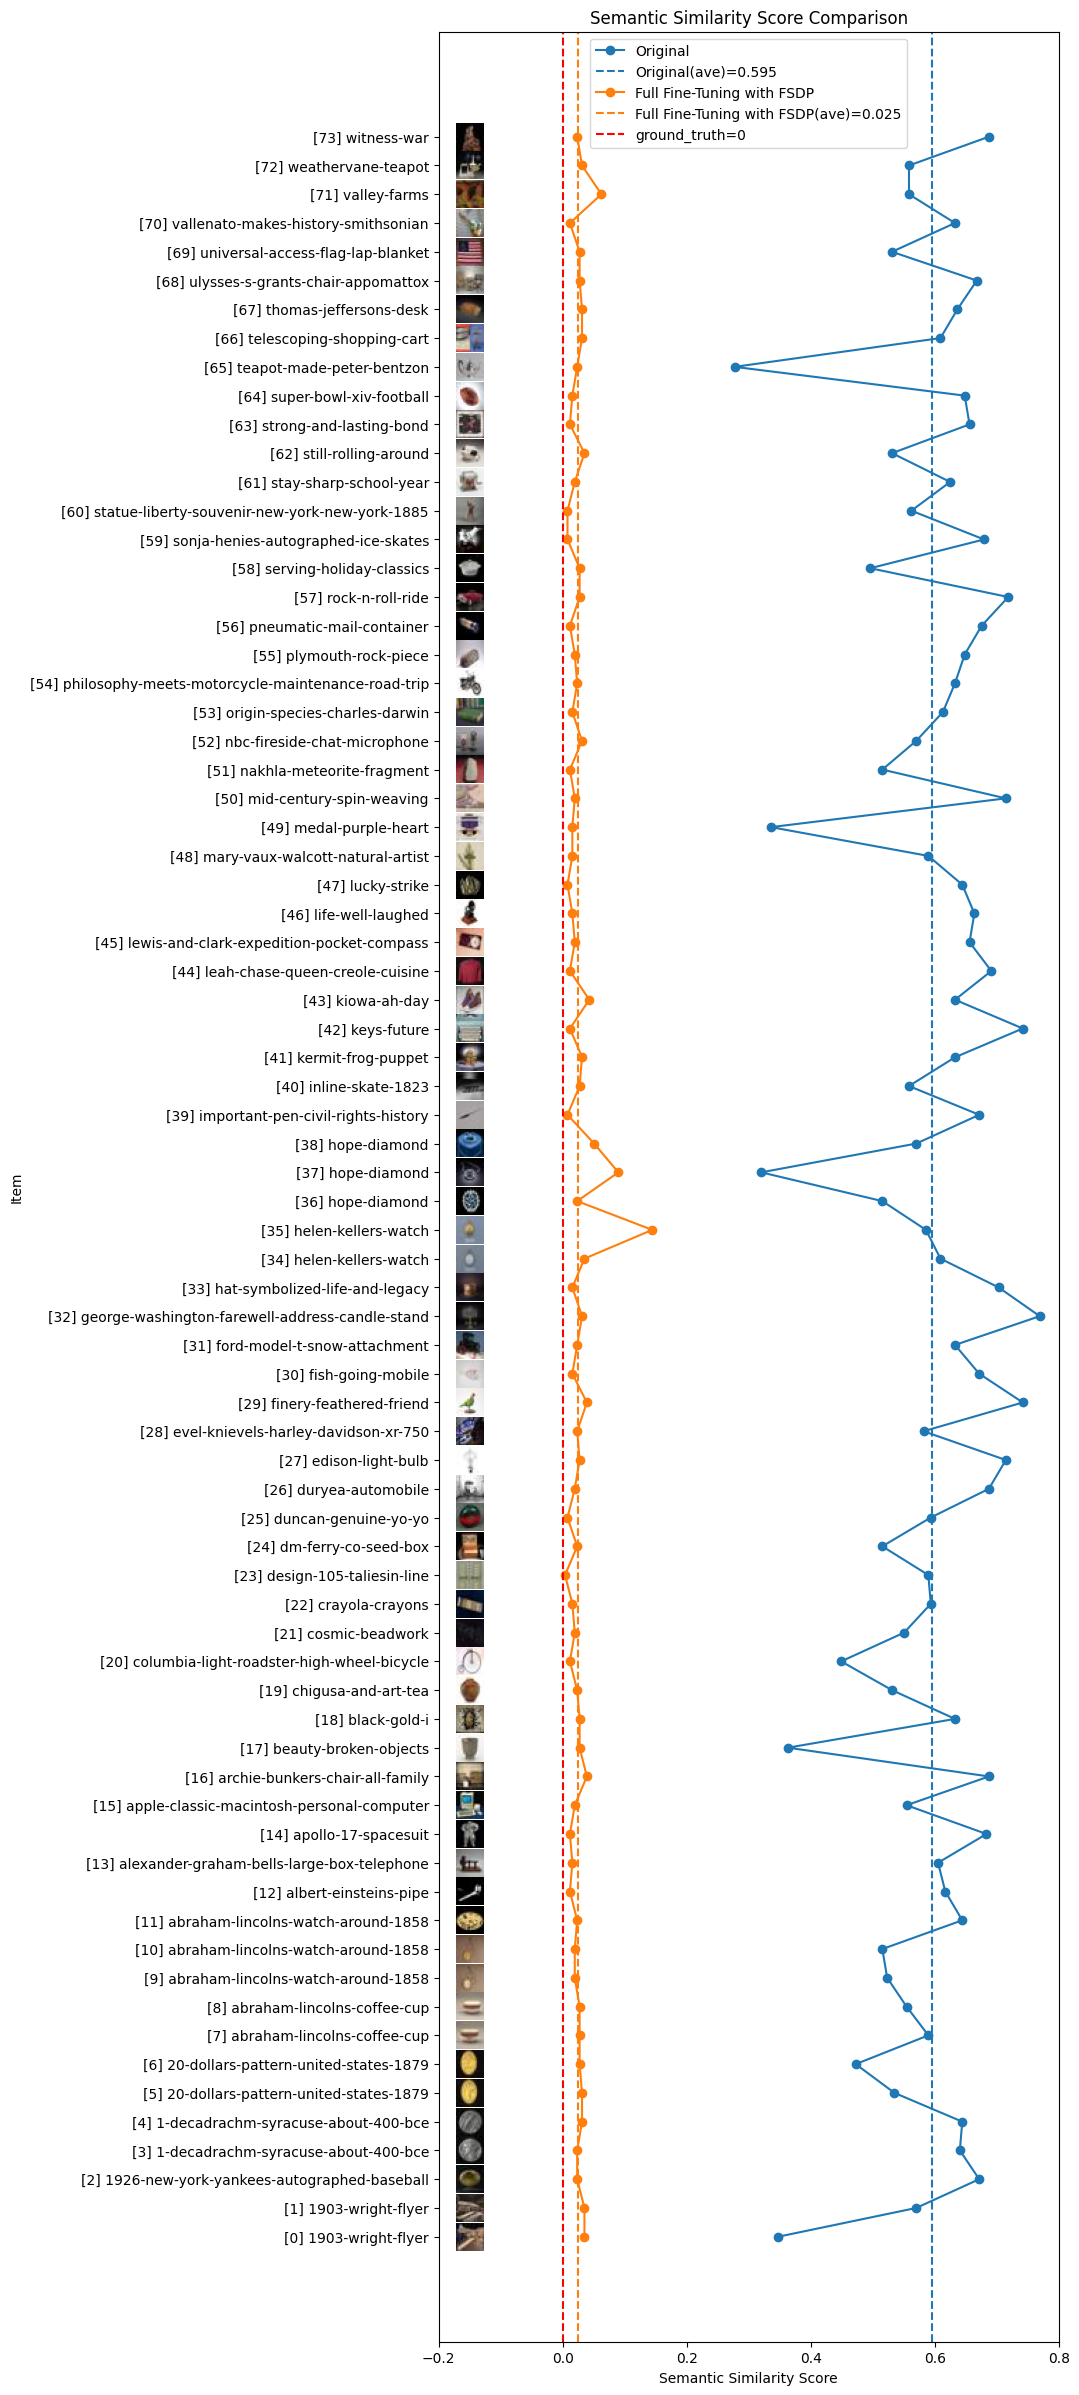

In [2]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(full_fine_tuning_model, processor, dataset['test'], './results/inference_results/inference_results_after_finetuning.csv', 14)

# Plot similarity scores (original vs. fine-tuned) from the inference CSV files, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv'),
                                 ('Full Fine-Tuning with FSDP', './results/inference_results/inference_results_after_finetuning.csv')],
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_after_finetuning.jpg')


## 3.4 Save the Fine-Tuned Model Locally  

In [3]:
# Save processor
print(f'==> Saving processor...')
my_utils.print_processor_info_to_file(processor, './results/model_info/updated_processor_info.txt')
processor.save_pretrained(save_directory='./results/finetuned_model')

# Save fine-tuned model
print(f'==> Saving fine-tuned model...')
my_utils.print_model_info_to_file(full_fine_tuning_model, './results/model_info/finetuned_model_info.txt')
my_utils.print_model_parameters_to_file(full_fine_tuning_model, './results/model_info/finetuned_model_parameters.txt')
full_fine_tuning_model.save_pretrained(save_directory='./results/finetuned_model')


==> Saving processor...
==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32004, bos_token: <s>, eos_token: </s>, pad_token: <pad>
==> For complete processor info, refer to ./results/model_info/updated_processor_info.txt.
==> Saving fine-tuned model...
==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': device(type='cpu')}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/finetuned_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, True)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, True)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.k_proj.weight (1327104, torch.bfloat16, cuda, Tru